# IBSR_18: Brain Tissue Segmentation Using Probabilistic ATLAS

**Author(s):** Mohammad Imran Hossain, Muhammad Zain Amin  
**Institute:** University of Girona (Spain), Erasmus Mundus Joint Master in Medical Imaging and Applications

This project is part of a course requirement for the Medical Image Segmentation and Application (MISA) module in the Erasmus Mundus Joint Master in Medical Imaging and Applications (MAIA) program at the University of Girona, Spain. The focus is on Brain Tissue (CSF, GM, WM) Segmentation from MR Images using a Statistical method (Probabilistic ATLAS).

### Dataset Overview

The challenge utilizes the Internet Brain Segmentation Repository (IBSR 18) dataset. The dataset encompasses 3D Brain MR Images with dimensions of (256, 128, 256) for model training and evaluation.

### Tissue Labels

- 0: Background
- 1: CSF
- 2: GM
- 3: WM

### Dataset Distribution

- Training Data: 10 
- Validation Data: 5 
- Testing Data: 3 

### Approach and Methodology

The project employs a Probabilistic ATLAS, a statistical-based segmentation approach, to segment the brain tissues (CSF, GM, WM) from the 3D Brain MR Images. Different types of registration parameters (Rigid, Affine, B-Spline) are used, employing Elastix-Transformix developed by SimpleITK. Segmentation performance will be evaluated using metrics such as Dice score (DSC) and Hausdorff distance (HD).

### Objective

The primary goal is to develop a robust and accurate classification system that can effectively distinguish between different types of brain tissues. This system aims to aid in the early detection of Brain Neurodegenerative diseases, contributing significantly to the fields of medical imaging and computer-aided diagnosis.
and computer-aided diagnosis.


# Necessary Libraries
- **Import all the necessary libraries**

In [1]:
import os
import itk
import utils
import shutil
import subprocess
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from typing import List
from pathlib import Path
import SimpleITK as sitk
import matplotlib.pyplot as plt
from tabulate import tabulate

# Path and Parameters
- **Define the path of the dataset directories and registration parameters**

In [2]:
# Define the path of the main directory
MAIN_PATH = Path('../IBSR_18_BraTS_ATLAS/').resolve()

# Define the path of the train and validation directories
TRAIN_DATASET_PATH = MAIN_PATH / 'Dataset/Training_Set'
VALID_DATASET_PATH = MAIN_PATH / 'Dataset/Validation_Set'

# Define the name of the registration parameters
rigid_parameter_name   = 'Parameters.Par0020.rigid.txt'
affine_parameter_name  = 'Parameters.Par0009.affine.txt'
bspline_parameter_name = 'Parameters.Par0009.bspline.txt'

# Define the path of the registration parameters 
RIGID_PARAMETER_PATH    = MAIN_PATH / 'Parameter'/ rigid_parameter_name
AFFINE_PARAMETER_PATH   = MAIN_PATH / 'Parameter'/ affine_parameter_name
BSPLINE_PARAMETER_PATH  = MAIN_PATH / 'Parameter'/ bspline_parameter_name

# Mutual Information

- **Compute the Mutual Information (MI) of the training dataset to select the fixed image for performing registration**

In [65]:
# Define a list to store mutual information for all image pairs
mutual_info_values = []

# Iterate over the training dataset to compute mutual information
for i, fixed_dir in tqdm(enumerate(TRAIN_DATASET_PATH.iterdir()), total=len(list(TRAIN_DATASET_PATH.iterdir())), desc='Registration Progressing'):
    
    # Read the fixed image f
    fixed_image_id   = fixed_dir.stem
    fixed_image_path = fixed_dir / f'{fixed_image_id}.nii.gz'
    fixed_image      = itk.imread(fixed_image_path, itk.F)

    # Initialize Elastix parameter object with default affine transformation settings
    parameter_object = itk.ParameterObject.New()
    default_affine_parameter_map = parameter_object.GetDefaultParameterMap('affine')
    parameter_object.AddParameterMap(default_affine_parameter_map)

    # List to hold mutual information values for the current fixed image with all moving images
    mutual_info_values_for_fixed_image = []  

    for j, moving_dir in enumerate(TRAIN_DATASET_PATH.iterdir()):
        
        # Read the moving image
        moving_image_id   = moving_dir.stem
        moving_image_path = moving_dir / f'{moving_image_id}.nii.gz'
        moving_image      = itk.imread(moving_image_path, itk.F)

        # Skip registration if fixed and moving images are the same
        if fixed_image_id == moving_image_id:
            continue
            
        # Perform registration using Elastix
        result_image, result_transform_parameters = itk.elastix_registration_method(
                                                        fixed_image, 
                                                        moving_image,
                                                        parameter_object=parameter_object,
                                                        log_to_console=True)

        # Calculate mutual information between the fixed and registered images
        mutual_info_value = utils.mutual_information(
                                itk.GetArrayFromImage(fixed_image), 
                                itk.GetArrayFromImage(result_image))

        # Append the computed mutual information to the list
        mutual_info_values_for_fixed_image.append(mutual_info_value)

    # Append the mutual information values for this fixed image to the main list
    mutual_info_values.append(mutual_info_values_for_fixed_image)


Registration Progressing: 100%|███████████████████████████████████████████████████████| 10/10 [20:20<00:00, 122.05s/it]


- **Plot the Mutual Information (MI) of training dataset for the visualization**

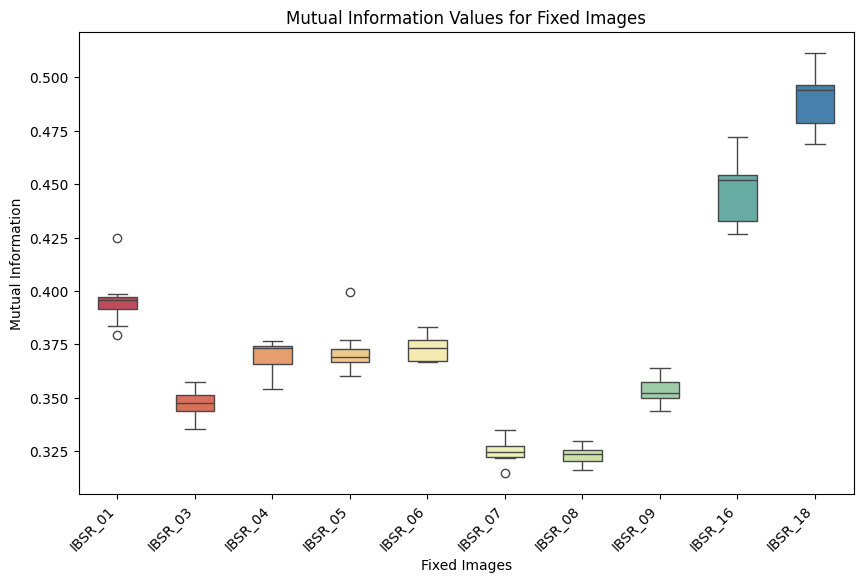

In [67]:
# Extract the IDs of the fixed images from the training dataset
fixed_image_ids = [fixed_dir.stem for fixed_dir in TRAIN_DATASET_PATH.iterdir()]

# Check that mutual_info_values is correctly structured as a list of lists
assert isinstance(mutual_info_values, list) and all(isinstance(sublist, list) for sublist in mutual_info_values)

# Flatten the mutual_info_values to a single list and create a corresponding list of fixed image IDs
flat_mutual_info_values = []
adjusted_fixed_image_ids = []
for idx, values in enumerate(mutual_info_values):
    fixed_image_id = fixed_image_ids[idx]

    # Extend the lists with the mutual information values and corresponding fixed image IDs
    adjusted_fixed_image_ids.extend([fixed_image_id] * len(values))
    flat_mutual_info_values.extend(values)

# Create a pandas DataFrame for data handling and visualization
data = pd.DataFrame({
    'Fixed Image ID': adjusted_fixed_image_ids,
    'Mutual Information': flat_mutual_info_values
})

# Setup for the boxplot visualization
plt.figure(figsize=(10, 6))
pastel_palette = sns.color_palette("Spectral", len(data['Fixed Image ID'].unique()))  

# Generate a boxplot to visualize mutual information values for each fixed image
sns.boxplot(x='Fixed Image ID', y='Mutual Information', data=data, palette=pastel_palette, width=0.5)

# Customize plot appearance
plt.xticks(rotation=45, ha="right")  
plt.xlabel("Fixed Images")
plt.ylabel("Mutual Information")
plt.title("Mutual Information Values for Fixed Images")
plt.legend([],[], frameon=False)  

# Display the plot
plt.show()


# Rigid Registration

- **Execute the training dataset registration using Rigid parameter settings**

In [25]:
# Set up the fixed image for registration
fixed_image_path = TRAIN_DATASET_PATH / 'IBSR_18' / 'IBSR_18.nii.gz'
fixed_image      = itk.imread(fixed_image_path, itk.F)

# Perform rigid registration across the training dataset
for k, moving_dir in tqdm(enumerate(TRAIN_DATASET_PATH.iterdir()), total=len(list(TRAIN_DATASET_PATH.iterdir())), desc='Registration Progressing'):

    # Load the moving image
    moving_image_id   = moving_dir.stem
    moving_image_path = moving_dir / f'{moving_image_id}.nii.gz'
    moving_image      = itk.imread(moving_image_path, itk.F)

    # Load the associated label of the moving image
    moving_label_path = moving_dir / f'{moving_image_id}_seg.nii.gz'
    moving_label      = itk.imread(moving_label_path, itk.F)

    # Define paths for saving the registered image and label
    reg_image_path = TRAIN_DATASET_PATH / moving_image_id / f'{moving_image_id}_reg_rigid.nii.gz'
    reg_label_path = TRAIN_DATASET_PATH / moving_image_id / f'{moving_image_id}_seg_reg_rigid.nii.gz'

    # Skip registration if the moving image is the same as the fixed image
    if moving_image_path.name == fixed_image_path.name:
        shutil.copy(moving_image_path, reg_image_path)
        shutil.copy(moving_label_path, reg_label_path)
        continue

    # Initialize parameter object with rigid transformation settings
    parameter_object = itk.ParameterObject.New()
    parameter_object.ReadParameterFile(str(RIGID_PARAMETER_PATH))
        
    # Execute the registration process using Elastix
    result_image, result_transform_parameters = itk.elastix_registration_method(
        fixed_image, moving_image,
        parameter_object=parameter_object,
        log_to_console=True)

    # Save the result of the registration
    itk.imwrite(result_image, reg_image_path)
    
    # Apply the transformation to the moving label
    transformix_image = itk.transformix_filter(moving_label, result_transform_parameters)

    # Save the transformed label
    itk.imwrite(transformix_image, reg_label_path)


Registration Progressing: 100%|████████████████████████████████████████████████████████| 10/10 [02:59<00:00, 17.97s/it]


#### Generate ATLAS
- **Create the Probabilistic and Topological ATLAS from the registered training image and labels**

In [3]:
# Initialize and read the reference image for atlas creation
ref_image_path  = TRAIN_DATASET_PATH /'IBSR_18'/ 'IBSR_18_reg_rigid.nii.gz'
ref_image       = sitk.ReadImage(str(ref_image_path))  
ref_image_array = sitk.GetArrayFromImage(ref_image)

# Define atlas configuration parameters
num_classes = 4  
num_volumes = len(list(TRAIN_DATASET_PATH.iterdir()))  
ref_image_shape = ref_image_array.shape 
labels_keys     = {0: 'background', 1: 'csf', 2: 'gm', 3: 'wm'}  

# Initialize accumulators for the atlases and mean volume
atlases     = np.zeros((num_classes, *ref_image_shape)).astype('float32')
mean_volume = np.zeros_like(ref_image_array).astype('float32')

# Iterate through each registered image and label for atlas accumulation
for i, image_dir in tqdm(enumerate(TRAIN_DATASET_PATH.iterdir()), total=num_volumes):

    # Define paths for the registered image and label
    image_id   = image_dir.stem
    image_path = image_dir / f'{image_id}_reg_rigid.nii.gz'
    label_path = image_dir / f'{image_id}_seg_reg_rigid.nii.gz'

    # Read and normalize the registered image; accumulate for mean volume calculation
    image = sitk.GetArrayFromImage(sitk.ReadImage(str(image_path)))
    image = ((image - image.min()) / (image.max() - image.min()) * 255).astype('uint8')
    mean_volume += image / num_volumes

    # Read the registered label and accumulate probabilistic atlas
    label = sitk.GetArrayFromImage(sitk.ReadImage(str(label_path)))
    for j in range(atlases.shape[0]):
        atlases[j] += np.where(label == j, 1, 0) / num_volumes

# Determine the topological atlas by finding the most frequent label at each voxel
topological_atlas = np.argmax(atlases, axis=0)

# Prepare output directory for saving atlas results
atlas_output_path = MAIN_PATH / 'Dataset' / "Atlases" / "Par0020.rigid"
atlas_output_path.mkdir(exist_ok=True, parents=True)

# Save each probabilistic and topological atlas, as well as the mean volume
for k in range(atlases.shape[0]):
    utils.save_atlas(atlases[k], ref_image, atlas_output_path / f'p_atlas_{labels_keys[k]}.nii.gz')
    utils.save_atlas(np.where(topological_atlas == k, 255, 0), ref_image, atlas_output_path / f't_atlas_{labels_keys[k]}.nii.gz')

utils.save_atlas(topological_atlas, ref_image, atlas_output_path / 't_atlas.nii.gz')
utils.save_atlas(mean_volume, ref_image, atlas_output_path / 'mean_volume.nii.gz')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


- **Visualize generated ATLAS**

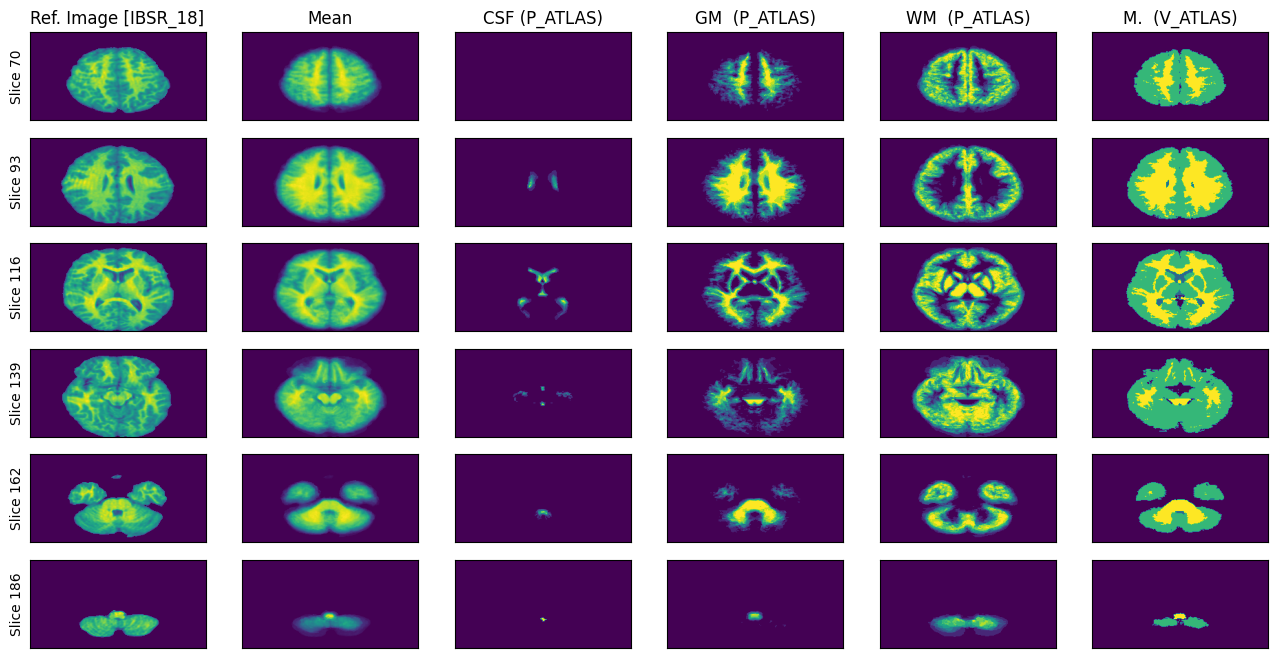

In [8]:
# Define the path of the dataset
data_path = MAIN_PATH / 'Dataset' 

# List of path of image and ATLAS file  
image_names = [
    'Training_Set/IBSR_18/IBSR_18.nii.gz',
    'Atlases/Par0020.rigid/mean_volume.nii.gz',
    'Atlases/Par0020.rigid/p_atlas_csf.nii.gz',
    'Atlases/Par0020.rigid/p_atlas_wm.nii.gz',
    'Atlases/Par0020.rigid/p_atlas_gm.nii.gz',
    'Atlases/Par0020.rigid/t_atlas.nii.gz']

# Corresponding titles for each image to be displayed in the plot
titles = [
    'Ref. Image [IBSR_18]',
    'Mean',
    'CSF (P_ATLAS)',
    'GM  (P_ATLAS)',
    'WM  (P_ATLAS)',
    'M.  (V_ATLAS)']

# Initialize the plot 
fig, ax = plt.subplots(6, len(image_names), figsize=(16, 8))

# Iterate through slices and image names to display each slice of each image
for i, slice_n in enumerate(np.linspace(70, (sitk.GetArrayFromImage(sitk.ReadImage(str(data_path / image_names[0]))).shape[0] - 70), 6).astype('int')):
    for j, img_name in enumerate(image_names):
        
        # Load each image and convert it to a NumPy array
        img = sitk.ReadImage(str(data_path / img_name))
        img_array = sitk.GetArrayFromImage(img)
        img_array = img_array[::-1, ::-1, ::-1]  

        # Add titles to the top row of the plot
        if i == 0:
            ax[i, j].set_title(titles[j])

        # Display the specified slice of each image
        ax[i, j].imshow(img_array[slice_n, :, :], cmap='viridis')
        ax[i, j].set_xticks([])  
        ax[i, j].set_yticks([])  

        # Label the y-axis of the first column with the slice number
        if j == 0:
            ax[i, j].set_ylabel(f'Slice {slice_n}')

# Render the complete plot
plt.show()


### Tissue Model

- **Generate the tissue model from the registered training image and labels**

In [9]:
# Define the path of ATLAS directory 
atlases_dir_path = MAIN_PATH / 'Dataset' / 'Atlases' / 'Par0020.rigid'

# Define the path of the reference image 
ref_image_path = TRAIN_DATASET_PATH / 'IBSR_18' / 'IBSR_18_reg_rigid.nii.gz'

# Read the topological atlas and the registered ground truth labels (reference)
t_atlas   = sitk.GetArrayFromImage(sitk.ReadImage(str(atlases_dir_path / 't_atlas.nii.gz')))
gt_labels = sitk.GetArrayFromImage(sitk.ReadImage(str(TRAIN_DATASET_PATH / 'IBSR_18' / 'IBSR_18_seg_reg_rigid.nii.gz')))

# Define the number of classes and their corresponding labels
num_classes = 4
labels_keys = {0: 'background', 1: 'csf', 2: 'gm', 3: 'wm'}

# Initialize histograms for the atlas and ground truth labels
t_histograms  = np.zeros((4, 50))
gt_histograms = np.zeros((4, 50))

# Iterate over each image in the training dataset
for i, image_dir in tqdm(enumerate(TRAIN_DATASET_PATH.iterdir()), total=len(list(TRAIN_DATASET_PATH.iterdir()))):

    # Define the path of the registered image and label
    image_id   = image_dir.stem
    image_path = image_dir / f'{image_id}_reg_rigid.nii.gz'
    moving_label_path = image_dir / f'{image_id}_seg_reg_rigid.nii.gz'

    # Read and normalize the moving image
    image_array = sitk.GetArrayFromImage(sitk.ReadImage(str(image_path)))
    image_array = ((image_array - image_array.min()) / (image_array.max() - image_array.min()) * 255).astype('uint8')
    image_label = sitk.GetArrayFromImage(sitk.ReadImage(str(moving_label_path)))

    # Compute and accumulate histograms for each class in both atlas and ground truth labels
    for j in range(num_classes):
        t_histograms[j]  += np.histogram(image_array[t_atlas == j], bins=50, range=[0, 256])[0]
        gt_histograms[j] += np.histogram(image_array[image_label == j], bins=50, range=[0, 256])[0]

# Calculate density histograms by normalizing histogram values
t_histograms_density = t_histograms / (np.sum(t_histograms, axis=1)[:, None] + 1e-8)
gt_histograms_density = gt_histograms / (np.sum(gt_histograms, axis=1)[:, None] + 1e-8)

# Sum the densities across all bins for each histogram type
t_sum = np.sum(t_histograms_density, axis=0)[None, :]
gt_sum = np.sum(gt_histograms_density, axis=0)[None, :]

# Calculate posterior histograms by dividing by the summed densities
t_histograms_posterior = t_histograms_density / (np.repeat(t_sum, 4, axis=0) + 1e-8)
gt_histograms_posterior = gt_histograms_density / (np.repeat(gt_sum, 4, axis=0) + 1e-8)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.67s/it]


- **Visualize the tissue model**

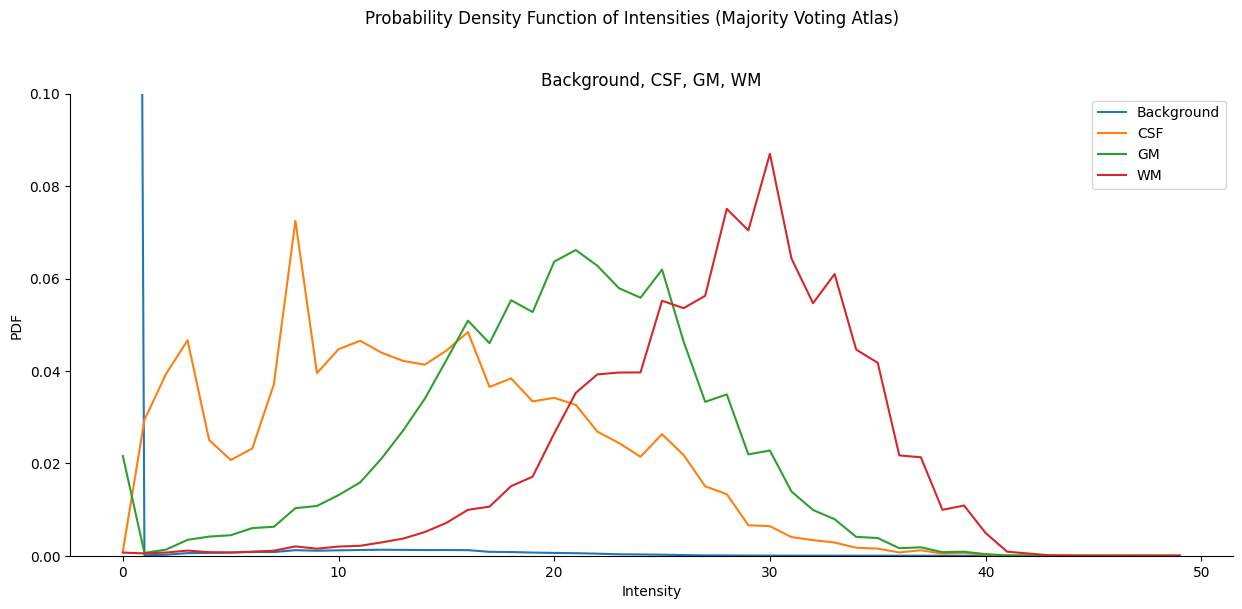

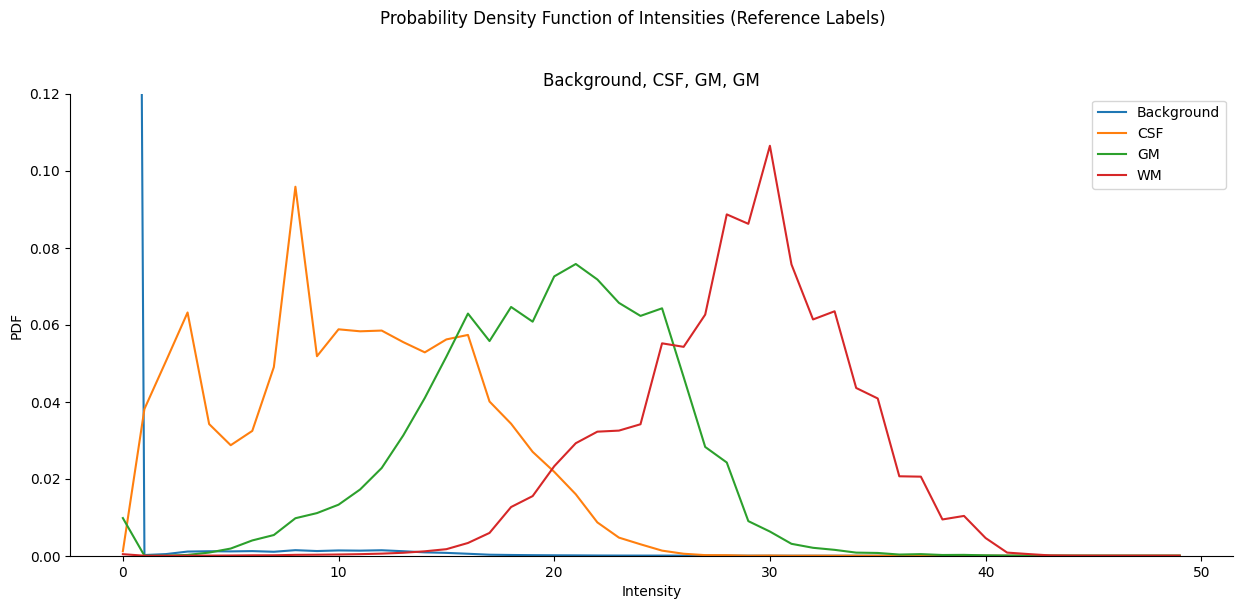

In [20]:
# Define the classes 
labels_keys = {0: 'Background', 1: 'CSF', 2: 'GM', 3: 'WM'}

# Plotting Probability Density Functions (PDF) for each class based on Majority Voting Atlas
plt.figure(figsize=(15, 6))
plt.suptitle('Probability Density Function of Intensities (Majority Voting Atlas)', y=1.02)

for c in range(num_classes):
    plt.plot(t_histograms_density[c, :], label=labels_keys[c])

plt.ylim([0, 0.1])
plt.ylabel('PDF')
plt.xlabel('Intensity')
plt.title('Background, CSF, GM, WM')
sns.despine()
plt.legend()
plt.show()

# Plotting Probability Density Functions (PDF) for each class based on Reference Labels
plt.figure(figsize=(15, 6))
plt.suptitle('Probability Density Function of Intensities (Reference Labels)', y=1.02)

for c in range(num_classes):
    plt.plot(gt_histograms_density[c, :], label=labels_keys[c])

plt.ylim([0, 0.12])
plt.ylabel('PDF')
plt.xlabel('Intensity')
plt.title('Background, CSF, GM, GM')
sns.despine()
plt.legend()
plt.show()

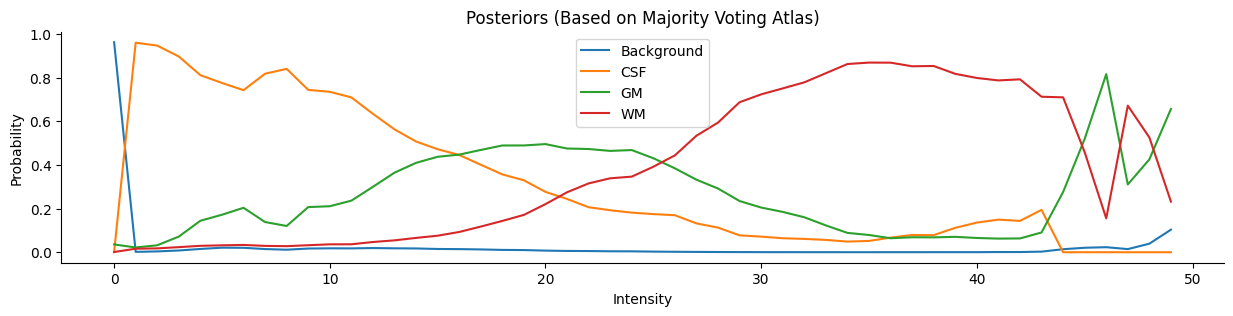

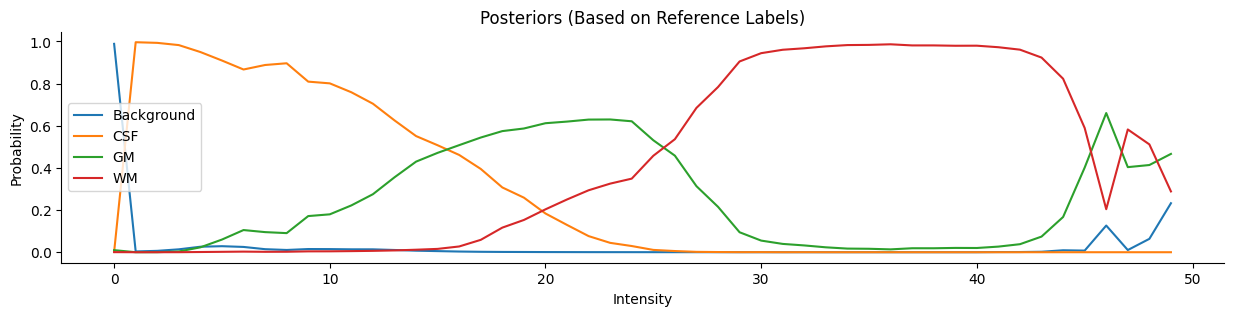

In [12]:
# Define the classes 
labels_keys = {0: 'Background', 1: 'CSF', 2: 'GM', 3: 'WM'}

# Plotting Posteriors for each class based on Majority Voting Atlas
plt.figure(figsize=(15, 3))
plt.title('Posteriors (Based on Majority Voting Atlas)')

for c in range(num_classes):
    plt.plot(t_histograms_posterior[c, :], label=labels_keys[c])

plt.ylabel('Probability')
plt.xlabel('Intensity')
sns.despine()
plt.legend()
plt.show()

# Plotting Posteriors for each class based on Reference Labels
plt.figure(figsize=(15, 3))
plt.title('Posteriors (Based on Reference Labels)')

for c in range(num_classes):
    plt.plot(gt_histograms_posterior[c, :], label=labels_keys[c])

plt.ylabel('Probability')
plt.xlabel('Intensity')
sns.despine()
plt.legend()
plt.show()

# Affine Registration

- **Execute the training dataset registration using Affine parameter settings**

In [13]:
# Set up the fixed image for registration
fixed_image_path = TRAIN_DATASET_PATH / 'IBSR_18' / 'IBSR_18.nii.gz'
fixed_image      = itk.imread(fixed_image_path, itk.F)

# Perform affine registration across the training dataset
for k, moving_dir in tqdm(enumerate(TRAIN_DATASET_PATH.iterdir()), total=len(list(TRAIN_DATASET_PATH.iterdir())), desc='Registration Progressing'):

    # Load the moving image
    moving_image_id   = moving_dir.stem
    moving_image_path = moving_dir / f'{moving_image_id}.nii.gz'
    moving_image      = itk.imread(moving_image_path, itk.F)

    # Load the associated label of the moving image
    moving_label_path = moving_dir / f'{moving_image_id}_seg.nii.gz'
    moving_label      = itk.imread(moving_label_path, itk.F)

    # Define paths for saving the registered image and label
    reg_image_path = TRAIN_DATASET_PATH / moving_image_id / f'{moving_image_id}_reg_affine.nii.gz'
    reg_label_path = TRAIN_DATASET_PATH / moving_image_id / f'{moving_image_id}_seg_reg_affine.nii.gz'

    # Skip registration if the moving image is the same as the fixed image
    if moving_image_path.name == fixed_image_path.name:
        shutil.copy(moving_image_path, reg_image_path)
        shutil.copy(moving_label_path, reg_label_path)
        continue

    # Initialize parameter object with affine transformation settings
    parameter_object = itk.ParameterObject.New()
    parameter_object.ReadParameterFile(str(AFFINE_PARAMETER_PATH))
        
    # Execute the registration process using Elastix
    result_image, result_transform_parameters = itk.elastix_registration_method(
        fixed_image, moving_image,
        parameter_object=parameter_object,
        log_to_console=True)

    # Save the result of the registration
    itk.imwrite(result_image, reg_image_path)
    
    # Apply the transformation to the moving label
    transformix_image = itk.transformix_filter(moving_label, result_transform_parameters)

    # Save the transformed label
    itk.imwrite(transformix_image, reg_label_path)


Registration Progressing: 100%|████████████████████████████████████████████████████████| 10/10 [03:44<00:00, 22.48s/it]


#### Generate ATLAS
- **Create the Probabilistic and Topological ATLAS from the registered training image and labels**

In [14]:
# Initialize and read the reference image for atlas creation
ref_image_path  = TRAIN_DATASET_PATH /'IBSR_18'/ 'IBSR_18_reg_affine.nii.gz'
ref_image       = sitk.ReadImage(str(ref_image_path))  
ref_image_array = sitk.GetArrayFromImage(ref_image)

# Define atlas configuration parameters
num_classes = 4  
num_volumes = len(list(TRAIN_DATASET_PATH.iterdir()))  
ref_image_shape = ref_image_array.shape 
labels_keys     = {0: 'background', 1: 'csf', 2: 'gm', 3: 'wm'}  

# Initialize accumulators for the atlases and mean volume
atlases     = np.zeros((num_classes, *ref_image_shape)).astype('float32')
mean_volume = np.zeros_like(ref_image_array).astype('float32')

# Iterate through each registered image and label for atlas accumulation
for i, image_dir in tqdm(enumerate(TRAIN_DATASET_PATH.iterdir()), total=num_volumes):

    # Define paths for the registered image and label
    image_id   = image_dir.stem
    image_path = image_dir / f'{image_id}_reg_affine.nii.gz'
    label_path = image_dir / f'{image_id}_seg_reg_affine.nii.gz'

    # Read and normalize the registered image; accumulate for mean volume calculation
    image = sitk.GetArrayFromImage(sitk.ReadImage(str(image_path)))
    image = ((image - image.min()) / (image.max() - image.min()) * 255).astype('uint8')
    mean_volume += image / num_volumes

    # Read the registered label and accumulate probabilistic atlas
    label = sitk.GetArrayFromImage(sitk.ReadImage(str(label_path)))
    for j in range(atlases.shape[0]):
        atlases[j] += np.where(label == j, 1, 0) / num_volumes

# Determine the topological atlas by finding the most frequent label at each voxel
topological_atlas = np.argmax(atlases, axis=0)

# Prepare output directory for saving atlas results
atlas_output_path = MAIN_PATH / 'Dataset' / "Atlases" / "Par0009.affine"
atlas_output_path.mkdir(exist_ok=True, parents=True)

# Save each probabilistic and topological atlas, as well as the mean volume
for k in range(atlases.shape[0]):
    utils.save_atlas(atlases[k], ref_image, atlas_output_path / f'p_atlas_{labels_keys[k]}.nii.gz')
    utils.save_atlas(np.where(topological_atlas == k, 255, 0), ref_image, atlas_output_path / f't_atlas_{labels_keys[k]}.nii.gz')

utils.save_atlas(topological_atlas, ref_image, atlas_output_path / 't_atlas.nii.gz')
utils.save_atlas(mean_volume, ref_image, atlas_output_path / 'mean_volume.nii.gz')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.60s/it]


- **Visualize generated ATLAS**

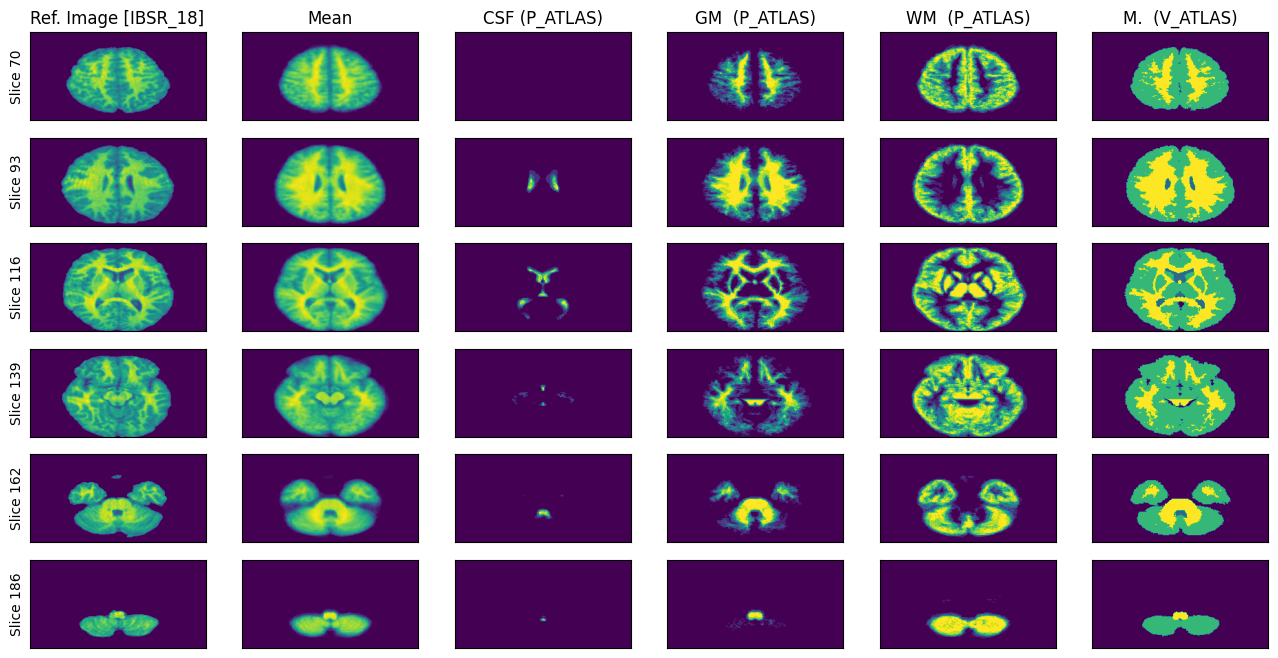

In [16]:
# Define the path of the dataset
data_path = MAIN_PATH / 'Dataset' 

# List of path of image and ATLAS file  
image_names = [
    'Training_Set/IBSR_18/IBSR_18.nii.gz',
    'Atlases/Par0009.affine/mean_volume.nii.gz',
    'Atlases/Par0009.affine/p_atlas_csf.nii.gz',
    'Atlases/Par0009.affine/p_atlas_wm.nii.gz',
    'Atlases/Par0009.affine/p_atlas_gm.nii.gz',
    'Atlases/Par0009.affine/t_atlas.nii.gz']

# Corresponding titles for each image to be displayed in the plot
titles = [
    'Ref. Image [IBSR_18]',
    'Mean',
    'CSF (P_ATLAS)',
    'GM  (P_ATLAS)',
    'WM  (P_ATLAS)',
    'M.  (V_ATLAS)']

# Initialize the plot 
fig, ax = plt.subplots(6, len(image_names), figsize=(16, 8))

# Iterate through slices and image names to display each slice of each image
for i, slice_n in enumerate(np.linspace(70, (sitk.GetArrayFromImage(sitk.ReadImage(str(data_path / image_names[0]))).shape[0] - 70), 6).astype('int')):
    for j, img_name in enumerate(image_names):
        
        # Load each image and convert it to a NumPy array
        img = sitk.ReadImage(str(data_path / img_name))
        img_array = sitk.GetArrayFromImage(img)
        img_array = img_array[::-1, ::-1, ::-1]  

        # Add titles to the top row of the plot
        if i == 0:
            ax[i, j].set_title(titles[j])

        # Display the specified slice of each image
        ax[i, j].imshow(img_array[slice_n, :, :], cmap='viridis')
        ax[i, j].set_xticks([])  
        ax[i, j].set_yticks([])  

        # Label the y-axis of the first column with the slice number
        if j == 0:
            ax[i, j].set_ylabel(f'Slice {slice_n}')

# Render the complete plot
plt.show()


### Tissue Model

- **Generate the tissue model from the registered training image and labels**

In [22]:
# Define the path of ATLAS directory 
atlases_dir_path = MAIN_PATH / 'Dataset' / 'Atlases' / 'Par0009.affine'

# Define the path of the reference image 
ref_image_path = TRAIN_DATASET_PATH / 'IBSR_18' / 'IBSR_18_reg_affine.nii.gz'

# Read the topological atlas and the registered ground truth labels (reference)
t_atlas   = sitk.GetArrayFromImage(sitk.ReadImage(str(atlases_dir_path / 't_atlas.nii.gz')))
gt_labels = sitk.GetArrayFromImage(sitk.ReadImage(str(TRAIN_DATASET_PATH / 'IBSR_18' / 'IBSR_18_seg_reg_affine.nii.gz')))

# Define the number of classes and their corresponding labels
num_classes = 4
labels_keys = {0: 'background', 1: 'csf', 2: 'gm', 3: 'wm'}

# Initialize histograms for the atlas and ground truth labels
t_histograms  = np.zeros((4, 50))
gt_histograms = np.zeros((4, 50))

# Iterate over each image in the training dataset
for i, image_dir in tqdm(enumerate(TRAIN_DATASET_PATH.iterdir()), total=len(list(TRAIN_DATASET_PATH.iterdir()))):

    # Define the path of the registered image and label
    image_id   = image_dir.stem
    image_path = image_dir / f'{image_id}_reg_affine.nii.gz'
    moving_label_path = image_dir / f'{image_id}_seg_reg_affine.nii.gz'

    # Read and normalize the moving image
    image_array = sitk.GetArrayFromImage(sitk.ReadImage(str(image_path)))
    image_array = ((image_array - image_array.min()) / (image_array.max() - image_array.min()) * 255).astype('uint8')
    image_label = sitk.GetArrayFromImage(sitk.ReadImage(str(moving_label_path)))

    # Compute and accumulate histograms for each class in both atlas and ground truth labels
    for j in range(num_classes):
        t_histograms[j]  += np.histogram(image_array[t_atlas == j], bins=50, range=[0, 256])[0]
        gt_histograms[j] += np.histogram(image_array[image_label == j], bins=50, range=[0, 256])[0]

# Calculate density histograms by normalizing histogram values
t_histograms_density = t_histograms / (np.sum(t_histograms, axis=1)[:, None] + 1e-8)
gt_histograms_density = gt_histograms / (np.sum(gt_histograms, axis=1)[:, None] + 1e-8)

# Sum the densities across all bins for each histogram type
t_sum = np.sum(t_histograms_density, axis=0)[None, :]
gt_sum = np.sum(gt_histograms_density, axis=0)[None, :]

# Calculate posterior histograms by dividing by the summed densities
t_histograms_posterior = t_histograms_density / (np.repeat(t_sum, 4, axis=0) + 1e-8)
gt_histograms_posterior = gt_histograms_density / (np.repeat(gt_sum, 4, axis=0) + 1e-8)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


- **Visualize the tissue model**

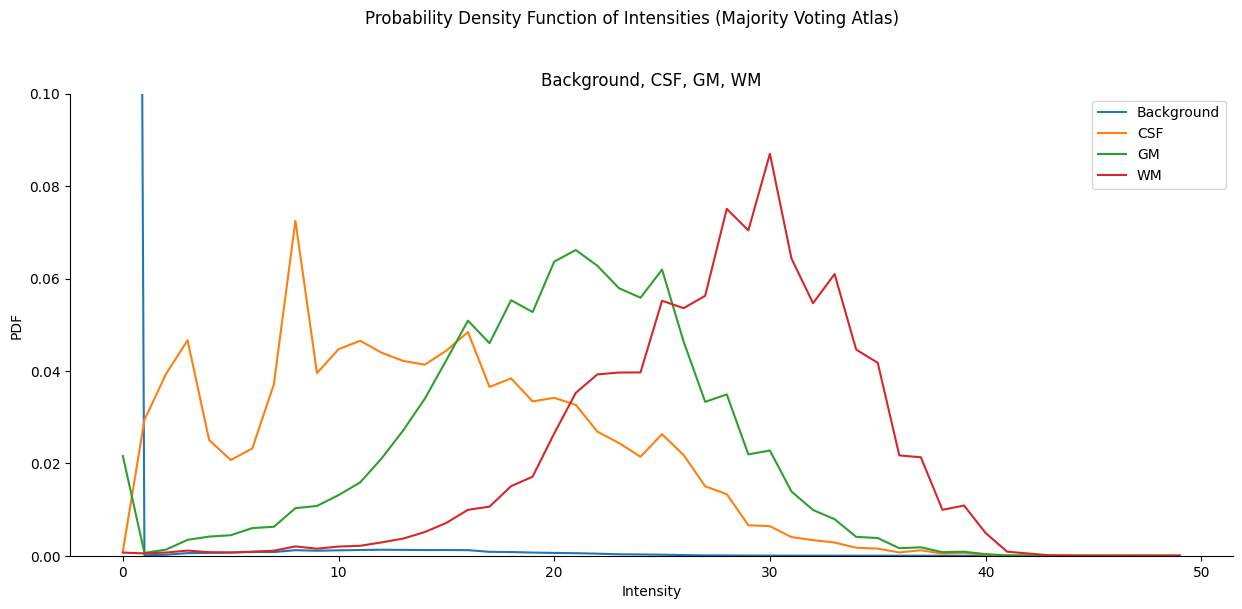

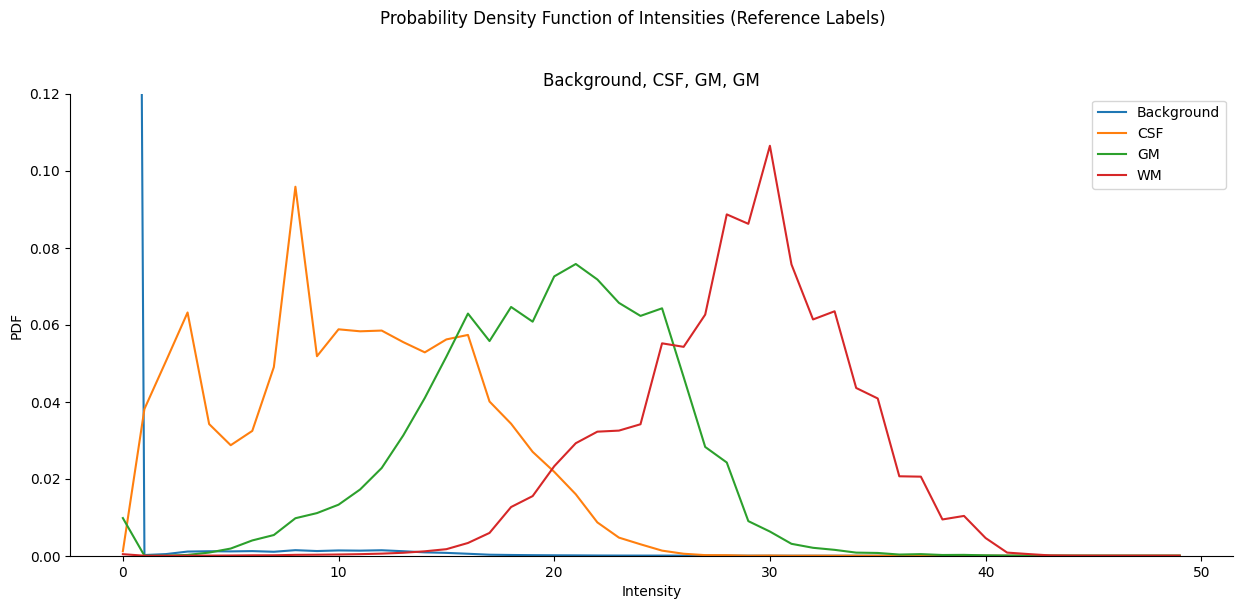

In [23]:
# Define the classes 
labels_keys = {0: 'Background', 1: 'CSF', 2: 'GM', 3: 'WM'}

# Plotting Probability Density Functions (PDF) for each class based on Majority Voting Atlas
plt.figure(figsize=(15, 6))
plt.suptitle('Probability Density Function of Intensities (Majority Voting Atlas)', y=1.02)

for c in range(num_classes):
    plt.plot(t_histograms_density[c, :], label=labels_keys[c])

plt.ylim([0, 0.1])
plt.ylabel('PDF')
plt.xlabel('Intensity')
plt.title('Background, CSF, GM, WM')
sns.despine()
plt.legend()
plt.show()

# Plotting Probability Density Functions (PDF) for each class based on Reference Labels
plt.figure(figsize=(15, 6))
plt.suptitle('Probability Density Function of Intensities (Reference Labels)', y=1.02)

for c in range(num_classes):
    plt.plot(gt_histograms_density[c, :], label=labels_keys[c])

plt.ylim([0, 0.12])
plt.ylabel('PDF')
plt.xlabel('Intensity')
plt.title('Background, CSF, GM, GM')
sns.despine()
plt.legend()
plt.show()

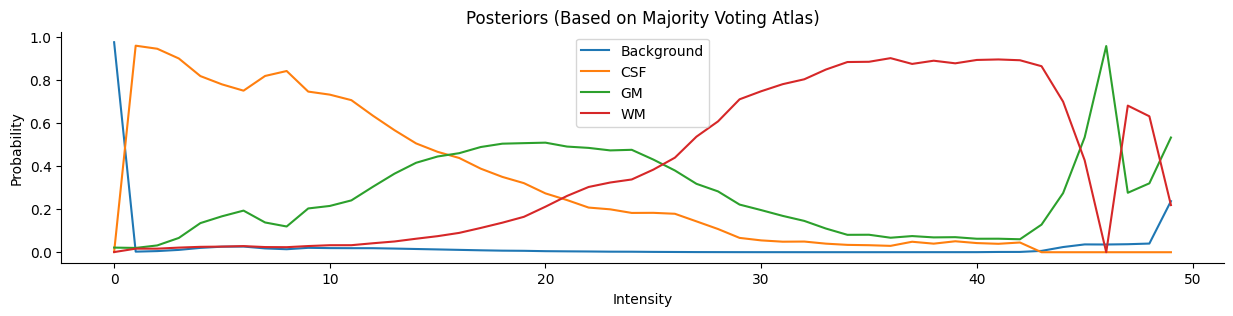

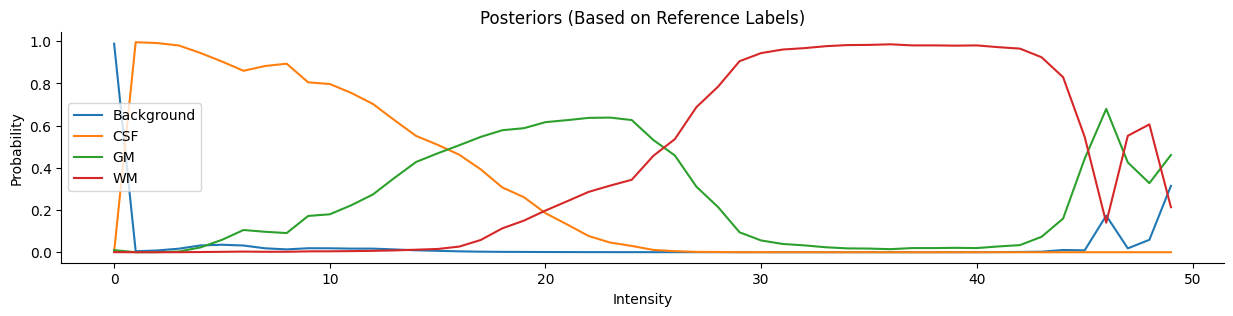

In [24]:
# Define the classes 
labels_keys = {0: 'Background', 1: 'CSF', 2: 'GM', 3: 'WM'}

# Plotting Posteriors for each class based on Majority Voting Atlas
plt.figure(figsize=(15, 3))
plt.title('Posteriors (Based on Majority Voting Atlas)')

for c in range(num_classes):
    plt.plot(t_histograms_posterior[c, :], label=labels_keys[c])

plt.ylabel('Probability')
plt.xlabel('Intensity')
sns.despine()
plt.legend()
plt.show()

# Plotting Posteriors for each class based on Reference Labels
plt.figure(figsize=(15, 3))
plt.title('Posteriors (Based on Reference Labels)')

for c in range(num_classes):
    plt.plot(gt_histograms_posterior[c, :], label=labels_keys[c])

plt.ylabel('Probability')
plt.xlabel('Intensity')
sns.despine()
plt.legend()
plt.show()

# B-Spline Registration

- **Execute the training dataset registration using B-Spline parameter settings**

In [ ]:
# Set up the fixed image for registration
fixed_image_path = TRAIN_DATASET_PATH / 'IBSR_18' / 'IBSR_18.nii.gz'
fixed_image      = itk.imread(fixed_image_path, itk.F)

# Perform bspline registration across the training dataset
for k, moving_dir in tqdm(enumerate(TRAIN_DATASET_PATH.iterdir()), total=len(list(TRAIN_DATASET_PATH.iterdir())), desc='Registration Progressing'):

    # Load the moving image
    moving_image_id   = moving_dir.stem
    moving_image_path = moving_dir / f'{moving_image_id}.nii.gz'
    moving_image      = itk.imread(moving_image_path, itk.F)

    # Load the associated label of the moving image
    moving_label_path = moving_dir / f'{moving_image_id}_seg.nii.gz'
    moving_label      = itk.imread(moving_label_path, itk.F)

    # Define paths for saving the registered image and label
    reg_image_path = TRAIN_DATASET_PATH / moving_image_id / f'{moving_image_id}_reg_bspline.nii.gz'
    reg_label_path = TRAIN_DATASET_PATH / moving_image_id / f'{moving_image_id}_seg_reg_bspline.nii.gz'

    # Skip registration if the moving image is the same as the fixed image
    if moving_image_path.name == fixed_image_path.name:
        shutil.copy(moving_image_path, reg_image_path)
        shutil.copy(moving_label_path, reg_label_path)
        continue

    # Initialize parameter object with bspline transformation settings
    parameter_object = itk.ParameterObject.New()
    #parameter_object.ReadParameterFile(str(RIGID_PARAMETER_PATH))
    parameter_object.ReadParameterFile(str(BSPLINE_PARAMETER_PATH))
        
    # Execute the registration process using Elastix
    result_image, result_transform_parameters = itk.elastix_registration_method(
        fixed_image, moving_image,
        parameter_object=parameter_object,
        log_to_console=True)

    # Save the result of the registration
    itk.imwrite(result_image, reg_image_path)
    
    # Apply the transformation to the moving label
    transformix_image = itk.transformix_filter(moving_label, result_transform_parameters)

    # Save the transformed label
    itk.imwrite(transformix_image, reg_label_path)


Registration Progressing:   0%|                                                                 | 0/10 [00:00<?, ?it/s]

### Generate Atlas

- **Create the Probabilistic and Topological ATLAS from the registered training image and labels**

In [13]:
# Initialize and read the reference image for atlas creation
ref_image_path  = TRAIN_DATASET_PATH /'IBSR_18'/ 'IBSR_18_reg_bspline.nii.gz'
ref_image       = sitk.ReadImage(str(ref_image_path))  
ref_image_array = sitk.GetArrayFromImage(ref_image)

# Define atlas configuration parameters
num_classes = 4  
num_volumes = len(list(TRAIN_DATASET_PATH.iterdir()))  
ref_image_shape = ref_image_array.shape 
labels_keys     = {0: 'background', 1: 'csf', 2: 'gm', 3: 'wm'}  

# Initialize accumulators for the atlases and mean volume
atlases     = np.zeros((num_classes, *ref_image_shape)).astype('float32')
mean_volume = np.zeros_like(ref_image_array).astype('float32')

# Iterate through each registered image and label for atlas accumulation
for i, image_dir in tqdm(enumerate(TRAIN_DATASET_PATH.iterdir()), total=num_volumes):

    # Define paths for the registered image and label
    image_id   = image_dir.stem
    image_path = image_dir / f'{image_id}_reg_bspline.nii.gz'
    label_path = image_dir / f'{image_id}_seg_reg_bspline.nii.gz'

    # Read and normalize the registered image; accumulate for mean volume calculation
    image = sitk.GetArrayFromImage(sitk.ReadImage(str(image_path)))
    image = ((image - image.min()) / (image.max() - image.min()) * 255).astype('uint8')
    mean_volume += image / num_volumes

    # Read the registered label and accumulate probabilistic atlas
    label = sitk.GetArrayFromImage(sitk.ReadImage(str(label_path)))
    for j in range(atlases.shape[0]):
        atlases[j] += np.where(label == j, 1, 0) / num_volumes

# Determine the topological atlas by finding the most frequent label at each voxel
topological_atlas = np.argmax(atlases, axis=0)

# Prepare output directory for saving atlas results
atlas_output_path = MAIN_PATH / 'Dataset' / "Atlases" / "Par0009.bspline"
atlas_output_path.mkdir(exist_ok=True, parents=True)

# Save each probabilistic and topological atlas, as well as the mean volume
for k in range(atlases.shape[0]):
    utils.save_atlas(atlases[k], ref_image, atlas_output_path / f'p_atlas_{labels_keys[k]}.nii.gz')
    utils.save_atlas(np.where(topological_atlas == k, 255, 0), ref_image, atlas_output_path / f't_atlas_{labels_keys[k]}.nii.gz')

utils.save_atlas(topological_atlas, ref_image, atlas_output_path / 't_atlas.nii.gz')
utils.save_atlas(mean_volume, ref_image, atlas_output_path / 'mean_volume.nii.gz')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.12it/s]


- **Visualize generated ATLAS**

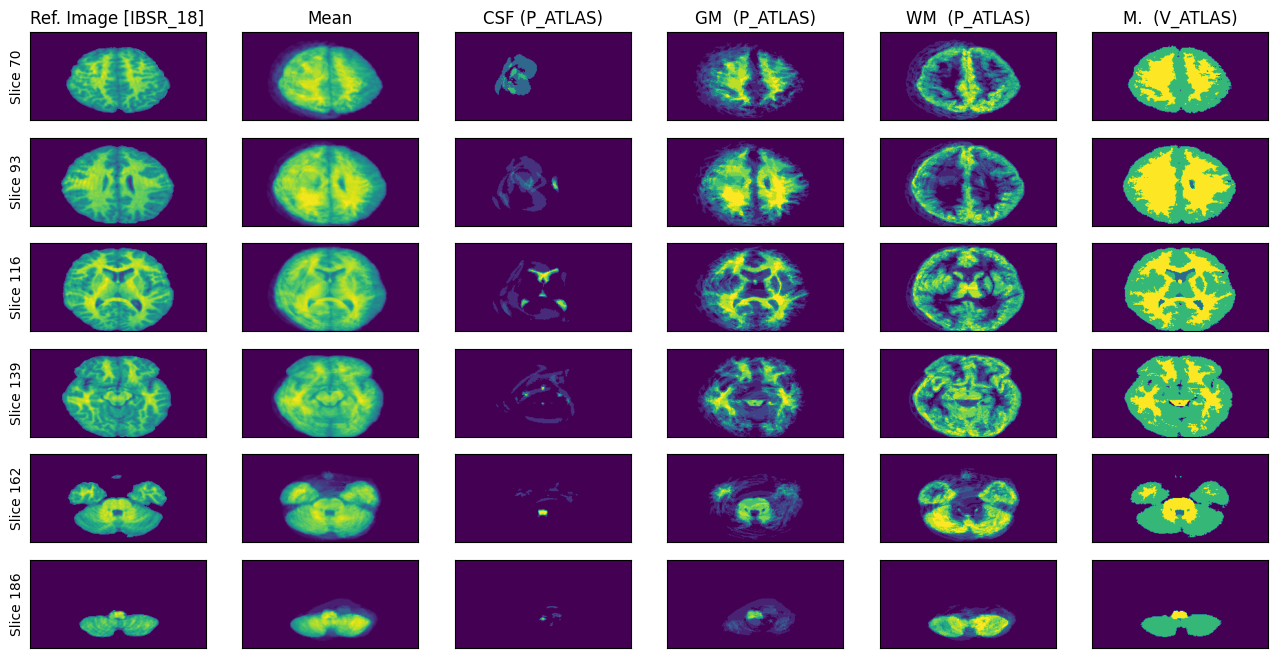

In [14]:
# Define the path of the dataset
data_path = MAIN_PATH / 'Dataset' 

# List of path of image and ATLAS file  
image_names = [
    'Training_Set/IBSR_18/IBSR_18.nii.gz',
    'Atlases/Par0009.bspline/mean_volume.nii.gz',
    'Atlases/Par0009.bspline/p_atlas_csf.nii.gz',
    'Atlases/Par0009.bspline/p_atlas_wm.nii.gz',
    'Atlases/Par0009.bspline/p_atlas_gm.nii.gz',
    'Atlases/Par0009.bspline/t_atlas.nii.gz']

# Corresponding titles for each image to be displayed in the plot
titles = [
    'Ref. Image [IBSR_18]',
    'Mean',
    'CSF (P_ATLAS)',
    'GM  (P_ATLAS)',
    'WM  (P_ATLAS)',
    'M.  (V_ATLAS)']

# Initialize the plot 
fig, ax = plt.subplots(6, len(image_names), figsize=(16, 8))

# Iterate through slices and image names to display each slice of each image
for i, slice_n in enumerate(np.linspace(70, (sitk.GetArrayFromImage(sitk.ReadImage(str(data_path / image_names[0]))).shape[0] - 70), 6).astype('int')):
    for j, img_name in enumerate(image_names):
        
        # Load each image and convert it to a NumPy array
        img = sitk.ReadImage(str(data_path / img_name))
        img_array = sitk.GetArrayFromImage(img)
        img_array = img_array[::-1, ::-1, ::-1]  

        # Add titles to the top row of the plot
        if i == 0:
            ax[i, j].set_title(titles[j])

        # Display the specified slice of each image
        ax[i, j].imshow(img_array[slice_n, :, :], cmap='viridis')
        ax[i, j].set_xticks([])  
        ax[i, j].set_yticks([])  

        # Label the y-axis of the first column with the slice number
        if j == 0:
            ax[i, j].set_ylabel(f'Slice {slice_n}')

# Render the complete plot
plt.show()


### Tissue Model

- **Generate the tissue model from the registered training image and labels**

In [15]:
# Define the path of ATLAS directory 
atlases_dir_path = MAIN_PATH / 'Dataset' / 'Atlases' / 'Par0009.bspline'

# Define the path of the reference image 
ref_image_path = TRAIN_DATASET_PATH / 'IBSR_18' / 'IBSR_18_reg_bspline.nii.gz'

# Read the topological atlas and the registered ground truth labels (reference)
t_atlas   = sitk.GetArrayFromImage(sitk.ReadImage(str(atlases_dir_path / 't_atlas.nii.gz')))
gt_labels = sitk.GetArrayFromImage(sitk.ReadImage(str(TRAIN_DATASET_PATH / 'IBSR_18' / 'IBSR_18_seg_reg_bspline.nii.gz')))

# Define the number of classes and their corresponding labels
num_classes = 4
labels_keys = {0: 'background', 1: 'csf', 2: 'gm', 3: 'wm'}

# Initialize histograms for the atlas and ground truth labels
t_histograms  = np.zeros((4, 255))
gt_histograms = np.zeros((4, 255))

# Iterate over each image in the training dataset
for i, image_dir in tqdm(enumerate(TRAIN_DATASET_PATH.iterdir()), total=len(list(TRAIN_DATASET_PATH.iterdir()))):

    # Define the path of the registered image and label
    image_id   = image_dir.stem
    image_path = image_dir / f'{image_id}_reg_bspline.nii.gz'
    moving_label_path = image_dir / f'{image_id}_seg_reg_bspline.nii.gz'

    # Read and normalize the moving image
    image_array = sitk.GetArrayFromImage(sitk.ReadImage(str(image_path)))
    image_array = ((image_array - image_array.min()) / (image_array.max() - image_array.min()) * 255).astype('uint8')
    image_label = sitk.GetArrayFromImage(sitk.ReadImage(str(moving_label_path)))

    # Compute and accumulate histograms for each class in both atlas and ground truth labels
    for j in range(num_classes):
        t_histograms[j]  += np.histogram(image_array[t_atlas == j], bins=255, range=[0, 256])[0]
        gt_histograms[j] += np.histogram(image_array[image_label == j], bins=255, range=[0, 256])[0]

# Calculate density histograms by normalizing histogram values
t_histograms_density = t_histograms / (np.sum(t_histograms, axis=1)[:, None] + 1e-8)
gt_histograms_density = gt_histograms / (np.sum(gt_histograms, axis=1)[:, None] + 1e-8)

# Sum the densities across all bins for each histogram type
t_sum = np.sum(t_histograms_density, axis=0)[None, :]
gt_sum = np.sum(gt_histograms_density, axis=0)[None, :]

# Calculate posterior histograms by dividing by the summed densities
t_histograms_posterior = t_histograms_density / (np.repeat(t_sum, 4, axis=0) + 1e-8)
gt_histograms_posterior = gt_histograms_density / (np.repeat(gt_sum, 4, axis=0) + 1e-8)

# Save the tissue model 
path_tissue_model = MAIN_PATH / 'Tissue Model' / 'bspline_tissue_model.npy'
np.save(path_tissue_model, gt_histograms_posterior)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.19it/s]


- **Visualize the tissue model**

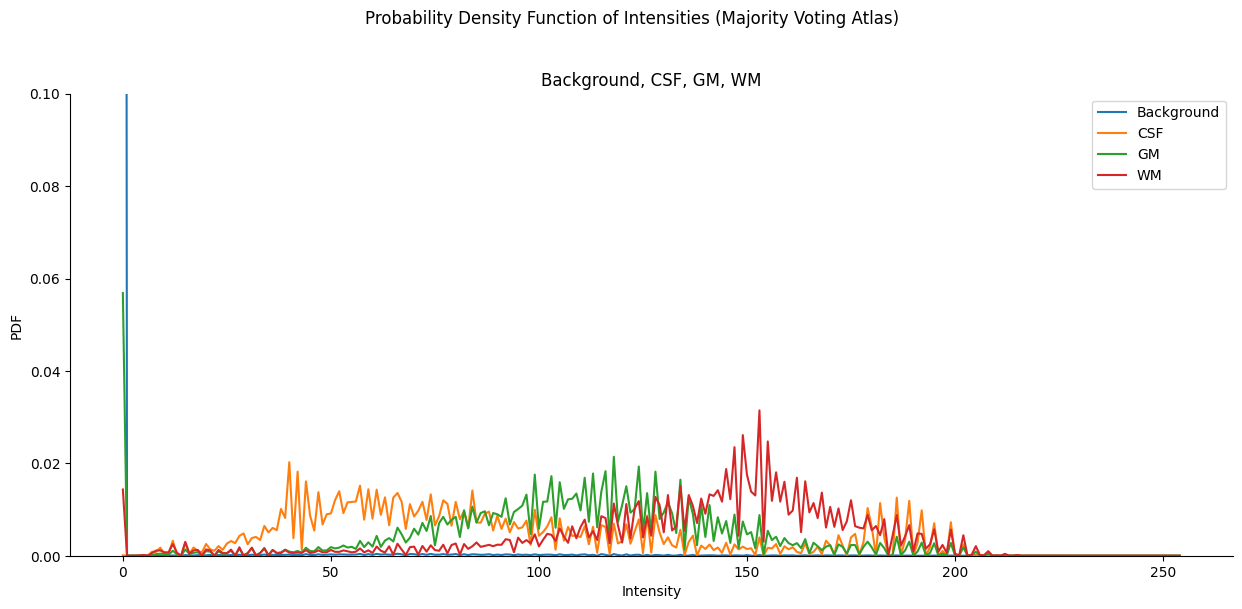

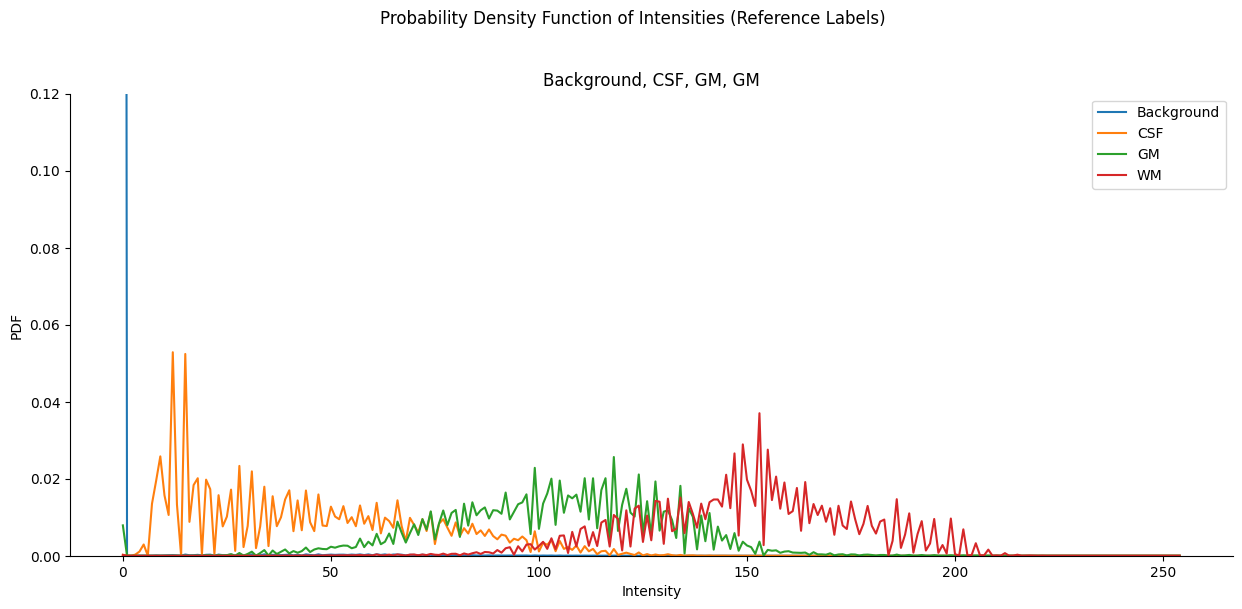

In [16]:
# Define the classes 
labels_keys = {0: 'Background', 1: 'CSF', 2: 'GM', 3: 'WM'}

# Plotting Probability Density Functions (PDF) for each class based on Majority Voting Atlas
plt.figure(figsize=(15, 6))
plt.suptitle('Probability Density Function of Intensities (Majority Voting Atlas)', y=1.02)

for c in range(num_classes):
    plt.plot(t_histograms_density[c, :], label=labels_keys[c])

plt.ylim([0, 0.1])
plt.ylabel('PDF')
plt.xlabel('Intensity')
plt.title('Background, CSF, GM, WM')
sns.despine()
plt.legend()
plt.show()

# Plotting Probability Density Functions (PDF) for each class based on Reference Labels
plt.figure(figsize=(15, 6))
plt.suptitle('Probability Density Function of Intensities (Reference Labels)', y=1.02)

for c in range(num_classes):
    plt.plot(gt_histograms_density[c, :], label=labels_keys[c])

plt.ylim([0, 0.12])
plt.ylabel('PDF')
plt.xlabel('Intensity')
plt.title('Background, CSF, GM, GM')
sns.despine()
plt.legend()
plt.show()

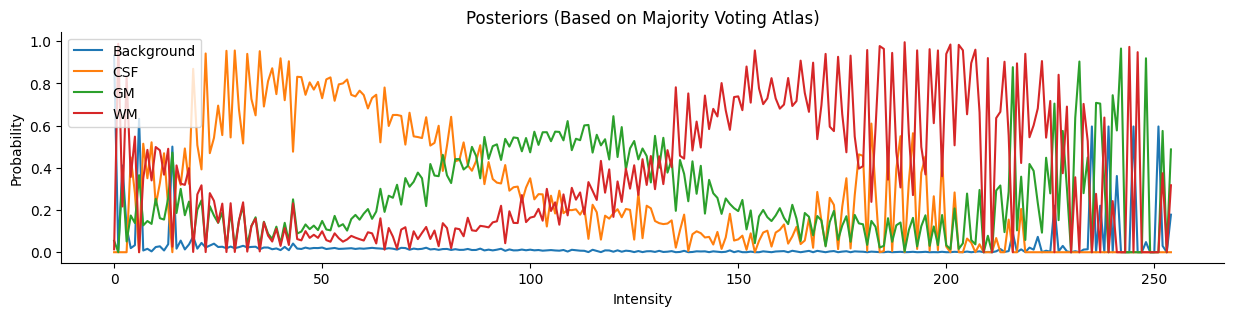

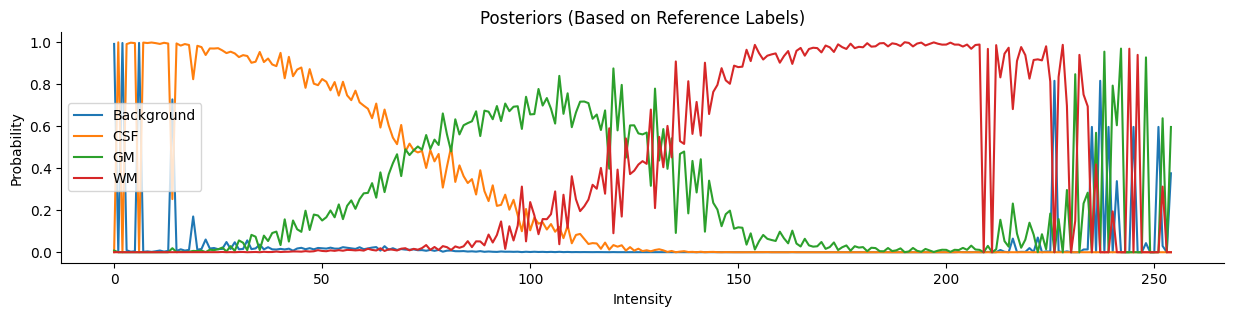

In [17]:
# Define the classes 
labels_keys = {0: 'Background', 1: 'CSF', 2: 'GM', 3: 'WM'}

# Plotting Posteriors for each class based on Majority Voting Atlas
plt.figure(figsize=(15, 3))
plt.title('Posteriors (Based on Majority Voting Atlas)')

for c in range(num_classes):
    plt.plot(t_histograms_posterior[c, :], label=labels_keys[c])

plt.ylabel('Probability')
plt.xlabel('Intensity')
sns.despine()
plt.legend()
plt.show()

# Plotting Posteriors for each class based on Reference Labels
plt.figure(figsize=(15, 3))
plt.title('Posteriors (Based on Reference Labels)')

for c in range(num_classes):
    plt.plot(gt_histograms_posterior[c, :], label=labels_keys[c])

plt.ylabel('Probability')
plt.xlabel('Intensity')
sns.despine()
plt.legend()
plt.show()

# Mutual Information

- **Visualize the Mutual Information (MI) of all the registration methods [Rigid, Affine, and B-Spline]**

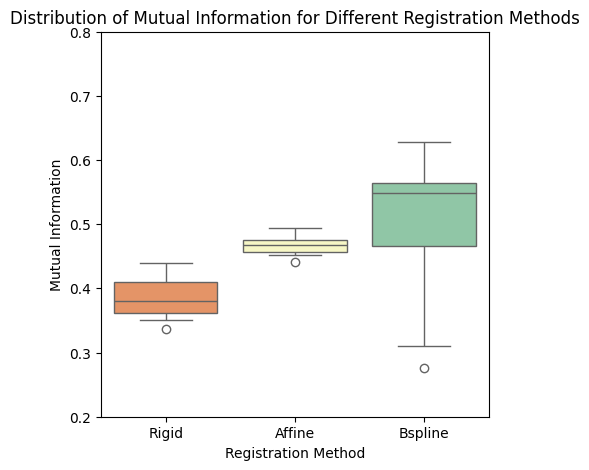

In [33]:
# List of registration parameters 
registration_parameters = ['rigid', 'affine', 'bspline']

# Initialize lists to store mutual information and registration methods
mutual_info_df = []
method_df = []

# Loop through different registration parameters
for reg_parameter in registration_parameters:
    for i, image_dir in enumerate(TRAIN_DATASET_PATH.iterdir()):
        
        # Read the moving image
        image_id          = image_dir.stem
        moving_image_path = image_dir / f'{image_id}_reg_{reg_parameter}.nii.gz'
        moving_image      = sitk.GetArrayFromImage(sitk.ReadImage(str(moving_image_path)))
        
        # Calculate mutual information directly
        hist_2d, _, _ = np.histogram2d(ref_image.ravel(), moving_image.ravel(), bins=255)
        pxy = hist_2d / float(np.sum(hist_2d))
        px = np.sum(pxy, axis=1)
        py = np.sum(pxy, axis=0)
        px_py = px[:, None] * py[None, :]
        nzs = pxy > 0
        mutual_info = np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))
        
        # Append mutual information and registration method to the lists
        mutual_info_df.append(mutual_info)
        method_df.append(reg_parameter)

# Create a DataFrame from the collected data
data = {'Method': method_df, 'MI': mutual_info_df}
mutual_information_df = pd.DataFrame(data)

# Plot the mutual information of all the registration method
plt.figure(figsize=(5, 5))

sns.boxplot(x='Method', y='MI', hue='Method', data=mutual_information_df, whis=[10, 90], palette='Spectral', legend=False)
plt.title('Distribution of Mutual Information for Different Registration Methods')
plt.xlabel('Registration Method')
plt.ylabel('Mutual Information')
plt.ylim([0.2, 0.8])
plt.xticks([0, 1, 2], ['Rigid', 'Affine', 'Bspline'])
plt.show()

- **Display the registered images using Rigid, Affine, and Bspline parameters**

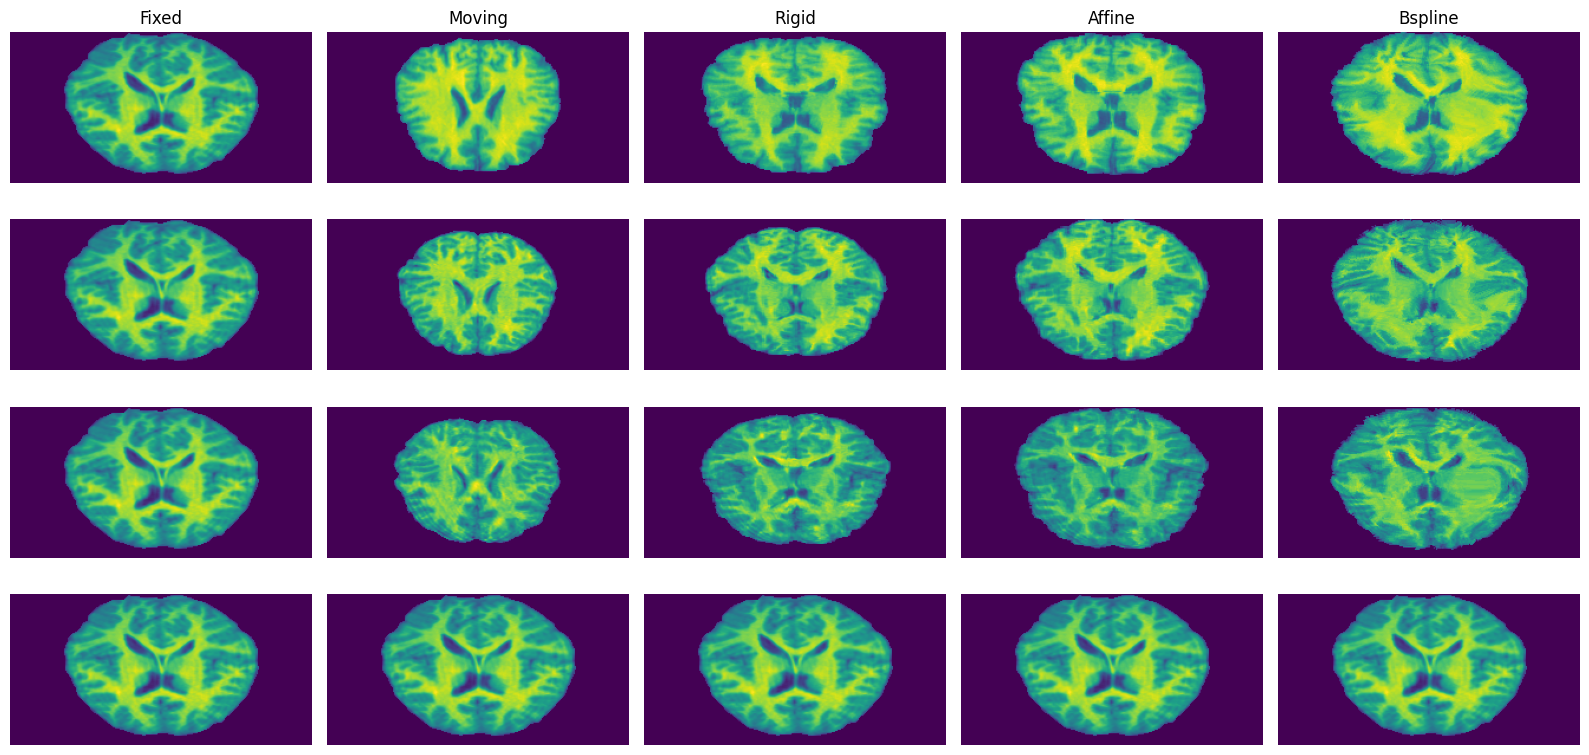

In [37]:
# Define the training dataset path
dataset_path = MAIN_PATH / 'Dataset' / 'Training_Set'

# Define the image IDs
image_ids = ['IBSR_01', 'IBSR_03', 'IBSR_04', 'IBSR_18']

# Lists to store images and labels for different transformations
images = []
labels = []
images_rigid = []
labels_rigid = []
images_afine = []
labels_afine = []
images_bspline = []
labels_bspline = []

# Iterate over image IDs to load images and labels for different transformations
for s in image_ids:
    # Original images and labels
    images.append(sitk.GetArrayFromImage(sitk.ReadImage(str(dataset_path / s / f'{s}.nii.gz'))))
    labels.append(sitk.GetArrayFromImage(sitk.ReadImage(str(dataset_path / s / f'{s}_seg.nii.gz'))))

    # Rigid transformed images and labels
    images_rigid.append(sitk.GetArrayFromImage(sitk.ReadImage(str(dataset_path / s / f'{s}_reg_rigid.nii.gz'))))
    labels_rigid.append(sitk.GetArrayFromImage(sitk.ReadImage(str(dataset_path / s / f'{s}_seg_reg_rigid.nii.gz'))))
    
    # Affine transformed images and labels
    images_afine.append(sitk.GetArrayFromImage(sitk.ReadImage(str(dataset_path / s / f'{s}_reg_affine.nii.gz'))))
    labels_afine.append(sitk.GetArrayFromImage(sitk.ReadImage(str(dataset_path / s / f'{s}_seg_reg_affine.nii.gz'))))
    
    # Bspline transformed images and labels
    images_bspline.append(sitk.GetArrayFromImage(sitk.ReadImage(str(dataset_path / s / f'{s}_reg_bspline.nii.gz'))))
    labels_bspline.append(sitk.GetArrayFromImage(sitk.ReadImage(str(dataset_path / s / f'{s}_reg_bspline.nii.gz'))))

# Plot images
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(16,8))

# Loop through the rows
for i in range(4):
    if i == 0:
        ax[i, 0].set_title(f'Fixed')
        ax[i, 1].set_title(f'Moving')
        ax[i, 2].set_title(f'Rigid')
        ax[i, 3].set_title(f'Affine')
        ax[i, 4].set_title(f'Bspline')
        
    # Display the reference image
    ax[i][0].imshow(ref_image[150, :, :], 'viridis')
    ax[i][0].axis('off')
    
    # Display the original image
    ax[i][1].imshow(images[i][150, :, :], 'viridis')
    ax[i][1].axis('off')

    # Display the rigid transformed image
    ax[i][2].imshow(images_rigid[i][150, :, :], 'viridis')
    ax[i][2].axis('off')
    
    # Display the affine transformed image
    ax[i][3].imshow(images_afine[i][150, :, :], 'viridis')
    ax[i][3].axis('off')
    
    # Display the bspline transformed image
    ax[i][4].imshow(images_bspline[i][150, :, :], 'viridis')
    ax[i][4].axis('off')

    # Set the y-axis label with the image ID, positioned at the middle of the row
    ax[i][0].set_ylabel(image_ids[i], rotation='horizontal', size='large', labelpad=20, horizontalalignment='right')

# Adjust the layout
plt.tight_layout()
plt.show()

# Segmentation: Validation Data 

- **Segment validation data using Probabilistic ATLAS generated by training data and Rigid registration**

In [39]:
# Define the path of the atlas directory
atlases_dir_path = MAIN_PATH / 'Dataset' / 'Atlases' / 'Par0020.rigid'

# Read the probabilistic atlas
probabilistic_atlas_path = atlases_dir_path / 'mean_volume.nii.gz'
probabilistic_atlas = itk.imread(str(probabilistic_atlas_path), itk.F)

# Read the topological atlas
topological_atlas_path = str(atlases_dir_path / 't_atlas.nii.gz')
topological_atlas = itk.imread(topological_atlas_path, itk.F)

# Iterate over the validation dataset for segmentation using the probabilistic atlas
for k, fixed_dir in tqdm(enumerate(VALID_DATASET_PATH.iterdir()), total=len(list(VALID_DATASET_PATH.iterdir())), desc='Registration Progressing'):
    
    # Read the fixed image from the validation dataset
    fixed_image_id = fixed_dir.stem
    fixed_image_path = fixed_dir / f'{fixed_image_id}.nii.gz'
    fixed_image = itk.imread(fixed_image_path, itk.F)

    # Define paths for saving registered image and label
    reg_image_path = VALID_DATASET_PATH / fixed_image_id / f'{fixed_image_id}_reg_rigid.nii.gz'
    reg_label_path = VALID_DATASET_PATH / fixed_image_id / f'{fixed_image_id}_seg_reg_rigid.nii.gz'

    # Skip registration if the fixed image is the same as the atlas
    if fixed_image_path.name == atlases_dir_path.name:
        shutil.copy(fixed_image_path, reg_image_path)
        continue

    # Read rigid transformation parameters
    parameter_object = itk.ParameterObject.New()
    parameter_object.ReadParameterFile(str(RIGID_PARAMETER_PATH))
        
    # Perform registration using Elastix
    result_image, result_transform_parameters = itk.elastix_registration_method(
        fixed_image, probabilistic_atlas,
        parameter_object=parameter_object,
        log_to_console=True)

    # Save the registered image
    itk.imwrite(result_image, reg_image_path)
    
    # Apply the transformation to the topological atlas
    transformix_image = itk.transformix_filter(topological_atlas, result_transform_parameters)
        
    # Save the transformed topological atlas as the segmentation label
    itk.imwrite(transformix_image, reg_label_path)


Registration Progressing: 100%|██████████████████████████████████████████████████████████| 5/5 [01:32<00:00, 18.53s/it]


- **Display the segmented images**

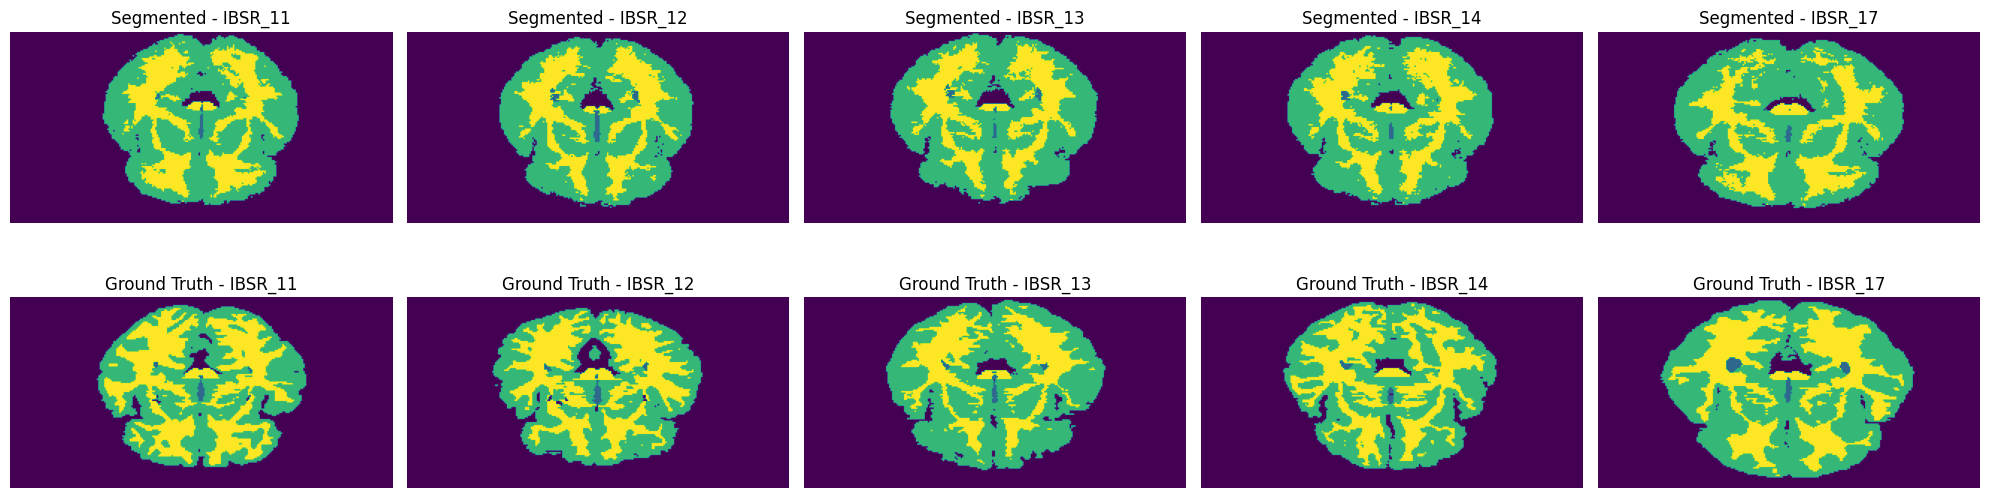

In [40]:
# Setup the plot 
fig, axs = plt.subplots(2, 5, figsize=(20, 6))

# Plot the segmented images 
for k, valid_dir in enumerate(VALID_DATASET_PATH.iterdir()):
    if k >= 5:
        break

    # Extract the image ID from the directory name
    image_id = valid_dir.stem

    # Define the slice number to be displayed
    slice_number = 125

    # Reading the ground truth label for the image
    valid_label_path = valid_dir / f'{image_id}_seg.nii.gz'
    valid_label = sitk.GetArrayFromImage(sitk.ReadImage(str(valid_label_path)))

    # Reading the segmented label for the image
    valid_seg_path = valid_dir / f'{image_id}_seg_reg_rigid.nii.gz'
    valid_seg = sitk.GetArrayFromImage(sitk.ReadImage(str(valid_seg_path)))

    # Plotting the specified slice of the segmented image
    axs[0, k].imshow(valid_seg[slice_number, :, :], cmap='viridis')
    axs[0, k].set_title(f'Segmented - {image_id}')
    axs[0, k].axis('off')  # Turn off axis labels and ticks

    # Plotting the same slice of the ground truth image
    axs[1, k].imshow(valid_label[slice_number, :, :], cmap='viridis')
    axs[1, k].set_title(f'Ground Truth - {image_id}')
    axs[1, k].axis('off')  # Turn off axis labels and ticks

# Adjust the layout of the plots to prevent overlap
plt.tight_layout()
# Display the plot
plt.show()


- **Compute dice scores**

In [49]:
# Initialize a list to store Dice scores for each image
dice_scores = []

# Iterate over each image in the validation dataset
for k, valid_dir in enumerate(VALID_DATASET_PATH.iterdir()):
    
    # Extract image ID from the directory name
    image_id = valid_dir.stem

    # Read the ground truth segmentation label
    valid_label_path = valid_dir / f'{image_id}_seg.nii.gz'
    valid_label = sitk.GetArrayFromImage(sitk.ReadImage(str(valid_label_path)))
    
    # Read the segmented image after registration
    valid_seg_path = valid_dir / f'{image_id}_seg_reg_rigid.nii.gz'
    valid_seg = sitk.GetArrayFromImage(sitk.ReadImage(str(valid_seg_path)))

    # Calculate Dice scores comparing the segmented image to the ground truth
    scores = utils.dice_score(valid_label, valid_seg)

    # Append the image ID to the scores for identification
    scores['ImageID'] = image_id
    dice_scores.append(scores)

# Convert the list of Dice scores to a pandas DataFrame
df_dice_scores = pd.DataFrame(dice_scores)
df_dice_scores = df_dice_scores.set_index('ImageID')
df_dice_scores.columns = ['Background', 'CSF', 'GM', 'WM']

# Calculate mean and standard deviation for each class
mean_scores = df_dice_scores.mean()
std_dev_scores = df_dice_scores.std()

# Calculate the average of the mean and standard deviation
avg_mean = mean_scores.mean()
avg_std_dev = std_dev_scores.mean()

# Display the DataFrame with mean and standard deviation
print("Dice Scores:")
print(df_dice_scores)
print("\nMean (DSC):")
print(mean_scores)
print("\nStandard Deviation (DSC):")
print(std_dev_scores)
print(f"\nAverage of Mean (DSC)     : {avg_mean}")
print(f"Average of Std. Dev. (DSC): {avg_std_dev}")


Dice Scores:
         Background       CSF        GM        WM
ImageID                                          
IBSR_11    0.991993  0.664314  0.735897  0.684527
IBSR_12    0.990038  0.667490  0.746894  0.702464
IBSR_13    0.992952  0.485438  0.814302  0.694725
IBSR_14    0.990696  0.669323  0.772329  0.706656
IBSR_17    0.980353  0.632612  0.720534  0.651320

Mean (DSC):
Background    0.989206
CSF           0.623835
GM            0.757991
WM            0.687939
dtype: float64

Standard Deviation (DSC):
Background    0.005076
CSF           0.078810
GM            0.036711
WM            0.022135
dtype: float64

Average of Mean (DSC)     : 0.7647428230629406
Average of Std. Dev. (DSC): 0.03568329781386686


- **Compute Hausdorff Distance**

In [50]:
# Initialize a list to store Hausdorff distances for each image
hd_scores = []

# Iterate over each image in the validation dataset
for k, valid_dir in enumerate(VALID_DATASET_PATH.iterdir()):
    
    # Extract image ID from the directory name
    image_id = valid_dir.stem

    # Read the ground truth segmentation label and segmented image
    valid_label_path = valid_dir / f'{image_id}_seg.nii.gz'
    valid_label = sitk.GetArrayFromImage(sitk.ReadImage(str(valid_label_path)))
    valid_seg_path = valid_dir / f'{image_id}_seg_reg_rigid.nii.gz'
    valid_seg = sitk.GetArrayFromImage(sitk.ReadImage(str(valid_seg_path)))

    # Calculate Hausdorff distances
    hd = utils.hausdorff_distance(valid_label, valid_seg)
    hd['ImageID'] = image_id
    hd_scores.append(hd)

# Convert the list of Hausdorff distances to a pandas DataFrame
df_hd_scores = pd.DataFrame(hd_scores)
df_hd_scores = df_hd_scores.set_index('ImageID')
df_hd_scores.columns = ['Background', 'CSF', 'GM', 'WM']

# Display the DataFrame
print("Hausdorff Distances:")
print(df_hd_scores)

# Calculate mean and standard deviation for each class
mean_scores    = df_hd_scores.mean()
std_dev_scores = df_hd_scores.std()

# Calculate the average of the mean and standard deviation
avg_mean       = mean_scores.mean()
avg_std_dev    = std_dev_scores.mean()

# Display the DataFrame with mean and standard deviation
print("\nMean (HD):")
print(mean_scores)
print("\nStandard Deviation (HD):")
print(std_dev_scores)

print(f"\nAverage of Mean (HD)     : {avg_mean}")
print(f"Average of Std. Dev. (HD): {avg_std_dev}")

Hausdorff Distances:
         Background       CSF         GM        WM
ImageID                                           
IBSR_11    7.141428  4.795832   7.416198  7.745967
IBSR_12    7.141428  4.582576   7.483315  7.615773
IBSR_13    6.633250  4.358899   7.348469  6.928203
IBSR_14    7.000000  3.872983   7.348469  7.549834
IBSR_17   10.049876  4.472136  10.049876  7.745967

Mean (HD):
Background    7.593196
CSF           4.416485
GM            7.929265
WM            7.517149
dtype: float64

Standard Deviation (HD):
Background    1.388960
CSF           0.343983
GM            1.186776
WM            0.339988
dtype: float64

Average of Mean (HD)     : 6.864023950831848
Average of Std. Dev. (HD): 0.8149266817147477


- **Compute Average Volumetric Difference**

In [51]:
# Initialize a list to store AVD scores for each image
avd_scores = []

# Iterate over each image in the validation dataset
for k, valid_dir in enumerate(VALID_DATASET_PATH.iterdir()):
    # Extract image ID from the directory name
    image_id = valid_dir.stem

    # Read the ground truth segmentation label
    valid_label_path = valid_dir / f'{image_id}_seg.nii.gz'
    valid_label = sitk.GetArrayFromImage(sitk.ReadImage(str(valid_label_path)))

    # Read the segmented image after registration
    valid_seg_path = valid_dir / f'{image_id}_seg_reg_rigid.nii.gz'
    valid_seg = sitk.GetArrayFromImage(sitk.ReadImage(str(valid_seg_path)))

    # Calculate AVD for each label in the segmented image
    scores = utils.volumetric_difference(valid_label, valid_seg)

    # Append the image ID to the scores for identification
    scores['ImageID'] = image_id
    avd_scores.append(scores)

# Convert the list of AVD scores to a pandas DataFrame and set index to ImageID
df_avd_scores = pd.DataFrame(avd_scores)
df_avd_scores = df_avd_scores.set_index('ImageID')
df_avd_scores.columns = ['Background', 'CSF', 'GM', 'WM']

print("Average Volumetric Difference:")
print(df_avd_scores)

# Calculate mean and standard deviation for each label
mean_scores = df_avd_scores.mean()
std_dev_scores = df_avd_scores.std()

# Calculate the overall average of the mean and standard deviation
avg_mean = mean_scores.mean()
avg_std_dev = std_dev_scores.mean()

# Display the DataFrame with mean and standard deviation
print("\nMean (AVD) :")
print(mean_scores)
print("\nStandard Deviation (AVD):")
print(std_dev_scores)

print(f"\nAverage of Mean (AVD)     : {avg_mean}")
print(f"Average of Std. Dev. (AVD): {avg_std_dev}")

Average Volumetric Difference:
         Background        CSF         GM         WM
ImageID                                             
IBSR_11    0.236350   5.724658  16.859766  30.143851
IBSR_12    0.138935  23.830882   9.328849  13.326534
IBSR_13    0.415946  16.013397   4.309193   0.355482
IBSR_14    1.183959   6.262174   0.316666  23.725505
IBSR_17    3.740296  34.393110  13.629693  23.883465

Mean (AVD) :
Background     1.143097
CSF           17.244844
GM             8.888833
WM            18.286967
dtype: float64

Standard Deviation (AVD):
Background     1.508840
CSF           12.168495
GM             6.720497
WM            11.700729
dtype: float64

Average of Mean (AVD)     : 11.390935556073012
Average of Std. Dev. (AVD): 8.02464015496144


- **Display the statistical analysis**

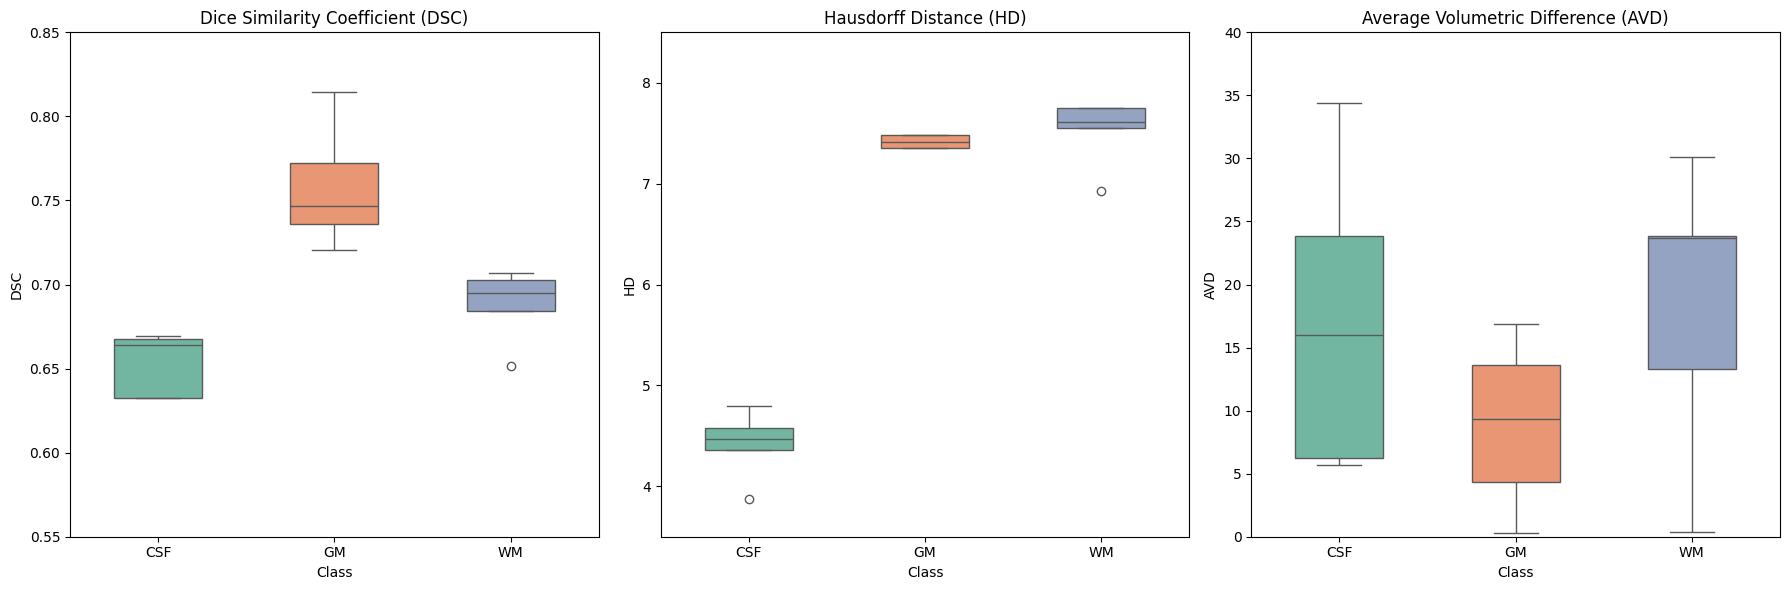

In [54]:
# Reshape the data into a long format
df_dice_long = df_dice_scores.melt(var_name='Class', value_name='DSC')
df_hd_long   = df_hd_scores.melt(var_name='Class', value_name='HD')
df_avd_long  = df_avd_scores.melt(var_name='Class', value_name='AVD')

# Combine the data into a single DataFrame
combined_data = pd.concat([df_dice_long, df_hd_long, df_avd_long], keys=['DSC', 'HD', 'AVD'])

# Correcting the DataFrame structure for combined data
combined_data = combined_data.reset_index(level=0).reset_index(drop=True)
combined_data.rename(columns={'level_0': 'Metric'}, inplace=True)

# Remove the 'Background' class from the DataFrame
combined_data = combined_data[combined_data['Class'] != 'Background']

# Number of unique classes
num_classes = combined_data['Class'].nunique()

# Define a color palette with the exact number of unique classes
palette = sns.color_palette("Set2", n_colors=num_classes)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

# DSC Plot
sns.boxplot(ax=axes[0], x='Class', y='DSC', hue='Class', data=combined_data[combined_data['Metric'] == 'DSC'], width=0.5, palette=palette)
axes[0].set_title('Dice Similarity Coefficient (DSC)')
axes[0].set_ylim([0.55, 0.85])  

# HD Plot
sns.boxplot(ax=axes[1], x='Class', y='HD', hue='Class', data=combined_data[combined_data['Metric'] == 'HD'], width=0.5, palette=palette)
axes[1].set_title('Hausdorff Distance (HD)')
axes[1].set_ylim([3.5, 8.5])  

# AVD Plot
sns.boxplot(ax=axes[2], x='Class', y='AVD', hue='Class', data=combined_data[combined_data['Metric'] == 'AVD'], width=0.5, palette=palette)
axes[2].set_title('Average Volumetric Difference (AVD)')
axes[2].set_ylim([0, 40])  

# Remove the legends
for ax in axes:
    ax.legend([],[], frameon=False)

plt.tight_layout()
plt.show()

- **Segment validation data using Probabilistic ATLAS generated by training data and Affine registration**

In [55]:
# Define the path of the atlas directory
atlases_dir_path = MAIN_PATH / 'Dataset' / 'Atlases' / 'Par0009.affine'

# Read the probabilistic atlas
probabilistic_atlas_path = atlases_dir_path / 'mean_volume.nii.gz'
probabilistic_atlas = itk.imread(str(probabilistic_atlas_path), itk.F)

# Read the topological atlas
topological_atlas_path = str(atlases_dir_path / 't_atlas.nii.gz')
topological_atlas = itk.imread(topological_atlas_path, itk.F)

# Iterate over the validation dataset for segmentation using the probabilistic atlas
for k, fixed_dir in tqdm(enumerate(VALID_DATASET_PATH.iterdir()), total=len(list(VALID_DATASET_PATH.iterdir())), desc='Registration Progressing'):
    
    # Read the fixed image from the validation dataset
    fixed_image_id = fixed_dir.stem
    fixed_image_path = fixed_dir / f'{fixed_image_id}.nii.gz'
    fixed_image = itk.imread(fixed_image_path, itk.F)

    # Define paths for saving registered image and label
    reg_image_path = VALID_DATASET_PATH / fixed_image_id / f'{fixed_image_id}_reg_affine.nii.gz'
    reg_label_path = VALID_DATASET_PATH / fixed_image_id / f'{fixed_image_id}_seg_reg_affine.nii.gz'

    # Skip registration if the fixed image is the same as the atlas
    if fixed_image_path.name == atlases_dir_path.name:
        shutil.copy(fixed_image_path, reg_image_path)
        continue

    # Read rigid transformation parameters
    parameter_object = itk.ParameterObject.New()
    parameter_object.ReadParameterFile(str(AFFINE_PARAMETER_PATH))
        
    # Perform registration using Elastix
    result_image, result_transform_parameters = itk.elastix_registration_method(
        fixed_image, probabilistic_atlas,
        parameter_object=parameter_object,
        log_to_console=True)

    # Save the registered image
    itk.imwrite(result_image, reg_image_path)
    
    # Apply the transformation to the topological atlas
    transformix_image = itk.transformix_filter(topological_atlas, result_transform_parameters)
        
    # Save the transformed topological atlas as the segmentation label
    itk.imwrite(transformix_image, reg_label_path)


Registration Progressing: 100%|██████████████████████████████████████████████████████████| 5/5 [01:58<00:00, 23.70s/it]


- **Display segmented images**

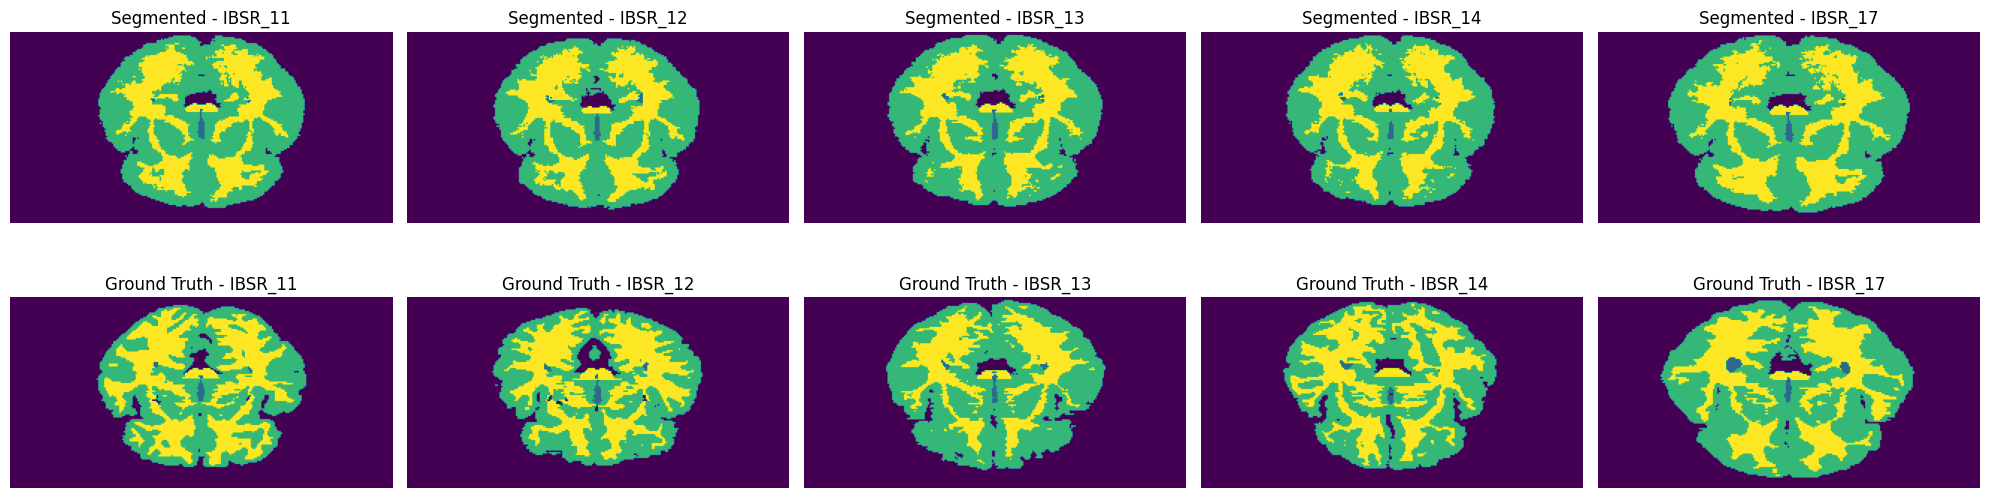

In [56]:
# Setup the plot 
fig, axs = plt.subplots(2, 5, figsize=(20, 6))

# Plot the segmented images 
for k, valid_dir in enumerate(VALID_DATASET_PATH.iterdir()):
    if k >= 5:
        break

    # Extract the image ID from the directory name
    image_id = valid_dir.stem

    # Define the slice number to be displayed
    slice_number = 125

    # Reading the ground truth label for the image
    valid_label_path = valid_dir / f'{image_id}_seg.nii.gz'
    valid_label = sitk.GetArrayFromImage(sitk.ReadImage(str(valid_label_path)))

    # Reading the segmented label for the image
    valid_seg_path = valid_dir / f'{image_id}_seg_reg_affine.nii.gz'
    valid_seg = sitk.GetArrayFromImage(sitk.ReadImage(str(valid_seg_path)))

    # Plotting the specified slice of the segmented image
    axs[0, k].imshow(valid_seg[slice_number, :, :], cmap='viridis')
    axs[0, k].set_title(f'Segmented - {image_id}')
    axs[0, k].axis('off')  # Turn off axis labels and ticks

    # Plotting the same slice of the ground truth image
    axs[1, k].imshow(valid_label[slice_number, :, :], cmap='viridis')
    axs[1, k].set_title(f'Ground Truth - {image_id}')
    axs[1, k].axis('off')  # Turn off axis labels and ticks

# Adjust the layout of the plots to prevent overlap
plt.tight_layout()
# Display the plot
plt.show()


- **Compute dice scores**

In [57]:
# Initialize a list to store Dice scores for each image
dice_scores = []

# Iterate over each image in the validation dataset
for k, valid_dir in enumerate(VALID_DATASET_PATH.iterdir()):
    
    # Extract image ID from the directory name
    image_id = valid_dir.stem

    # Read the ground truth segmentation label
    valid_label_path = valid_dir / f'{image_id}_seg.nii.gz'
    valid_label = sitk.GetArrayFromImage(sitk.ReadImage(str(valid_label_path)))
    
    # Read the segmented image after rigid registration
    valid_seg_path = valid_dir / f'{image_id}_seg_reg_affine.nii.gz'
    valid_seg = sitk.GetArrayFromImage(sitk.ReadImage(str(valid_seg_path)))

    # Calculate Dice scores comparing the segmented image to the ground truth
    scores = utils.dice_score(valid_label, valid_seg)

    # Append the image ID to the scores for identification
    scores['ImageID'] = image_id
    dice_scores.append(scores)

# Convert the list of Dice scores to a pandas DataFrame
df_dice_scores = pd.DataFrame(dice_scores)
df_dice_scores = df_dice_scores.set_index('ImageID')
df_dice_scores.columns = ['Background', 'CSF', 'GM', 'WM']

# Calculate mean and standard deviation for each class
mean_scores = df_dice_scores.mean()
std_dev_scores = df_dice_scores.std()

# Calculate the average of the mean and standard deviation
avg_mean = mean_scores.mean()
avg_std_dev = std_dev_scores.mean()

# Display the DataFrame with mean and standard deviation
print("Dice Scores:")
print(df_dice_scores)
print("\nMean (DSC):")
print(mean_scores)
print("\nStandard Deviation (DSC):")
print(std_dev_scores)
print(f"\nAverage of Mean (DSC)     : {avg_mean}")
print(f"Average of Std. Dev. (DSC): {avg_std_dev}")



Dice Scores:
         Background       CSF        GM        WM
ImageID                                          
IBSR_11    0.991160  0.653372  0.747550  0.703995
IBSR_12    0.988740  0.705176  0.740199  0.693188
IBSR_13    0.992573  0.581342  0.818384  0.705370
IBSR_14    0.992958  0.724242  0.807998  0.727585
IBSR_17    0.990199  0.708407  0.807848  0.689756

Mean (DSC):
Background    0.991126
CSF           0.674508
GM            0.784396
WM            0.703979
dtype: float64

Standard Deviation (DSC):
Background    0.001732
CSF           0.058502
GM            0.037327
WM            0.014815
dtype: float64

Average of Mean (DSC)     : 0.7885021121217016
Average of Std. Dev. (DSC): 0.028093943474854468


- **Compute Hausdorff Distance**

In [58]:
# Initialize a list to store Hausdorff distances for each image
hd_scores = []

# Iterate over each image in the validation dataset
for k, valid_dir in enumerate(VALID_DATASET_PATH.iterdir()):
    
    # Extract image ID from the directory name
    image_id = valid_dir.stem

    # Read the ground truth segmentation label and segmented image
    valid_label_path = valid_dir / f'{image_id}_seg.nii.gz'
    valid_label = sitk.GetArrayFromImage(sitk.ReadImage(str(valid_label_path)))
    valid_seg_path = valid_dir / f'{image_id}_seg_reg_affine.nii.gz'
    valid_seg = sitk.GetArrayFromImage(sitk.ReadImage(str(valid_seg_path)))

    # Calculate Hausdorff distances
    hd = utils.hausdorff_distance(valid_label, valid_seg)
    hd['ImageID'] = image_id
    hd_scores.append(hd)

# Convert the list of Hausdorff distances to a pandas DataFrame
df_hd_scores = pd.DataFrame(hd_scores)
df_hd_scores = df_hd_scores.set_index('ImageID')
df_hd_scores.columns = ['Background', 'CSF', 'GM', 'WM']

# Display the DataFrame
print("Hausdorff Distances:")
print(df_hd_scores)

# Calculate mean and standard deviation for each class
mean_scores    = df_hd_scores.mean()
std_dev_scores = df_hd_scores.std()

# Calculate the average of the mean and standard deviation
avg_mean       = mean_scores.mean()
avg_std_dev    = std_dev_scores.mean()

# Display the DataFrame with mean and standard deviation
print("\nMean (HD):")
print(mean_scores)
print("\nStandard Deviation (HD):")
print(std_dev_scores)

print(f"\nAverage of Mean (HD)     : {avg_mean}")
print(f"Average of Std. Dev. (HD): {avg_std_dev}")

Hausdorff Distances:
         Background       CSF        GM        WM
ImageID                                          
IBSR_11    7.745967  4.795832  7.874008  7.141428
IBSR_12    6.855655  4.582576  7.211103  7.348469
IBSR_13    6.928203  4.242641  7.348469  6.855655
IBSR_14    6.633250  3.872983  7.141428  7.348469
IBSR_17    7.810250  4.000000  8.062258  7.416198

Mean (HD):
Background    7.194665
CSF           4.298806
GM            7.527453
WM            7.222044
dtype: float64

Standard Deviation (HD):
Background    0.544058
CSF           0.387725
GM            0.414501
WM            0.229348
dtype: float64

Average of Mean (HD)     : 6.560742041708672
Average of Std. Dev. (HD): 0.39390812754735965


- **Compute Average Volumetric Difference**

In [59]:
# Initialize a list to store AVD scores for each image
avd_scores = []

# Iterate over each image in the validation dataset
for k, valid_dir in enumerate(VALID_DATASET_PATH.iterdir()):
    # Extract image ID from the directory name
    image_id = valid_dir.stem

    # Read the ground truth segmentation label
    valid_label_path = valid_dir / f'{image_id}_seg.nii.gz'
    valid_label = sitk.GetArrayFromImage(sitk.ReadImage(str(valid_label_path)))

    # Read the segmented image after B-spline registration
    valid_seg_path = valid_dir / f'{image_id}_seg_reg_affine.nii.gz'
    valid_seg = sitk.GetArrayFromImage(sitk.ReadImage(str(valid_seg_path)))

    # Calculate AVD for each label in the segmented image
    scores = utils.volumetric_difference(valid_label, valid_seg)

    # Append the image ID to the scores for identification
    scores['ImageID'] = image_id
    avd_scores.append(scores)

# Convert the list of AVD scores to a pandas DataFrame and set index to ImageID
df_avd_scores = pd.DataFrame(avd_scores)
df_avd_scores = df_avd_scores.set_index('ImageID')
df_avd_scores.columns = ['Background', 'CSF', 'GM', 'WM']

print("Average Volumetric Difference:")
print(df_avd_scores)

# Calculate mean and standard deviation for each label
mean_scores = df_avd_scores.mean()
std_dev_scores = df_avd_scores.std()

# Calculate the overall average of the mean and standard deviation
avg_mean = mean_scores.mean()
avg_std_dev = std_dev_scores.mean()

# Display the DataFrame with mean and standard deviation
print("\nMean (AVD) :")
print(mean_scores)
print("\nStandard Deviation (AVD):")
print(std_dev_scores)

print(f"\nAverage of Mean (AVD)     : {avg_mean}")
print(f"Average of Std. Dev. (AVD): {avg_std_dev}")

Average Volumetric Difference:
         Background        CSF         GM         WM
ImageID                                             
IBSR_11    1.259020  24.043563  31.659169  20.976653
IBSR_12    1.694781  12.050656  23.819135   1.380293
IBSR_13    0.794760  36.371866   4.088799   8.737933
IBSR_14    0.268495   6.002453  10.849702  15.276930
IBSR_17    0.154160  18.094012   3.364935   8.647851

Mean (AVD) :
Background     0.834243
CSF           19.312510
GM            14.756348
WM            11.003932
dtype: float64

Standard Deviation (AVD):
Background     0.652898
CSF           11.670276
GM            12.516612
WM             7.433269
dtype: float64

Average of Mean (AVD)     : 11.476758303007914
Average of Std. Dev. (AVD): 8.06826370086126


- **Display the statistical analysis**

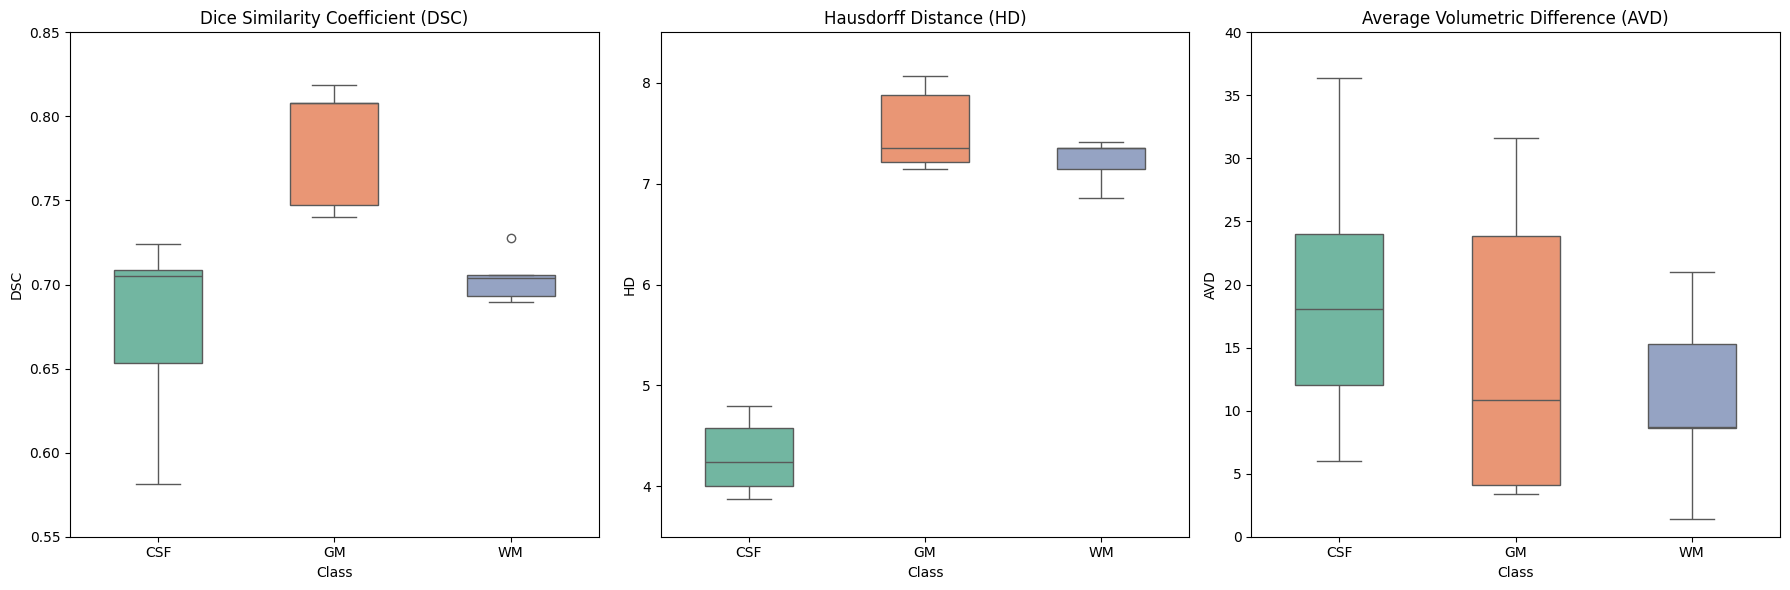

In [60]:
# Reshape the data into a long format
df_dice_long = df_dice_scores.melt(var_name='Class', value_name='DSC')
df_hd_long   = df_hd_scores.melt(var_name='Class', value_name='HD')
df_avd_long  = df_avd_scores.melt(var_name='Class', value_name='AVD')

# Combine the data into a single DataFrame
combined_data = pd.concat([df_dice_long, df_hd_long, df_avd_long], keys=['DSC', 'HD', 'AVD'])

# Correcting the DataFrame structure for combined data
combined_data = combined_data.reset_index(level=0).reset_index(drop=True)
combined_data.rename(columns={'level_0': 'Metric'}, inplace=True)

# Remove the 'Background' class from the DataFrame
combined_data = combined_data[combined_data['Class'] != 'Background']

# Number of unique classes
num_classes = combined_data['Class'].nunique()

# Define a color palette with the exact number of unique classes
palette = sns.color_palette("Set2", n_colors=num_classes)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

# DSC Plot
sns.boxplot(ax=axes[0], x='Class', y='DSC', hue='Class', data=combined_data[combined_data['Metric'] == 'DSC'], width=0.5, palette=palette)
axes[0].set_title('Dice Similarity Coefficient (DSC)')
axes[0].set_ylim([0.55, 0.85])  

# HD Plot
sns.boxplot(ax=axes[1], x='Class', y='HD', hue='Class', data=combined_data[combined_data['Metric'] == 'HD'], width=0.5, palette=palette)
axes[1].set_title('Hausdorff Distance (HD)')
axes[1].set_ylim([3.5, 8.5])  

# AVD Plot
sns.boxplot(ax=axes[2], x='Class', y='AVD', hue='Class', data=combined_data[combined_data['Metric'] == 'AVD'], width=0.5, palette=palette)
axes[2].set_title('Average Volumetric Difference (AVD)')
axes[2].set_ylim([0, 40])  

# Remove the legends
for ax in axes:
    ax.legend([],[], frameon=False)

plt.tight_layout()
plt.show()

- **Segment validation images using Probabilistic ATLAS generated by training data and B-Spline registration**

In [18]:
# Define the path of the atlas directory
atlases_dir_path = MAIN_PATH / 'Dataset' / 'Atlases' / 'Par0009.bspline'

# Read the probabilistic atlas
probabilistic_atlas_path = atlases_dir_path / 'mean_volume.nii.gz'
probabilistic_atlas = itk.imread(str(probabilistic_atlas_path), itk.F)

# Read the topological atlas
topological_atlas_path = str(atlases_dir_path / 't_atlas.nii.gz')
topological_atlas = itk.imread(topological_atlas_path, itk.F)

# Iterate over the validation dataset for segmentation using the probabilistic atlas
for k, fixed_dir in tqdm(enumerate(VALID_DATASET_PATH.iterdir()), total=len(list(VALID_DATASET_PATH.iterdir())), desc='Registration Progressing'):
    
    # Read the fixed image from the validation dataset
    fixed_image_id = fixed_dir.stem
    fixed_image_path = fixed_dir / f'{fixed_image_id}.nii.gz'
    fixed_image = itk.imread(fixed_image_path, itk.F)

    # Define paths for saving registered image and label
    reg_image_path = VALID_DATASET_PATH / fixed_image_id / f'{fixed_image_id}_reg_bspline.nii.gz'
    reg_label_path = VALID_DATASET_PATH / fixed_image_id / f'{fixed_image_id}_seg_reg_bspline.nii.gz'

    # Skip registration if the fixed image is the same as the atlas
    if fixed_image_path.name == atlases_dir_path.name:
        shutil.copy(fixed_image_path, reg_image_path)
        continue

    # Read rigid transformation parameters
    parameter_object = itk.ParameterObject.New()
    parameter_object.ReadParameterFile(str(AFFINE_PARAMETER_PATH))
    parameter_object.ReadParameterFile(str(BSPLINE_PARAMETER_PATH))
        
    # Perform registration using Elastix
    result_image, result_transform_parameters = itk.elastix_registration_method(
        fixed_image, probabilistic_atlas,
        parameter_object=parameter_object,
        log_to_console=True)

    # Save the registered image
    itk.imwrite(result_image, reg_image_path)
    
    # Apply the transformation to the topological atlas
    transformix_image = itk.transformix_filter(topological_atlas, result_transform_parameters)
        
    # Save the transformed topological atlas as the segmentation label
    itk.imwrite(transformix_image, reg_label_path)


Registration Progressing: 100%|██████████████████████████████████████████████████████████| 5/5 [01:06<00:00, 13.33s/it]


- **Display segmented images**

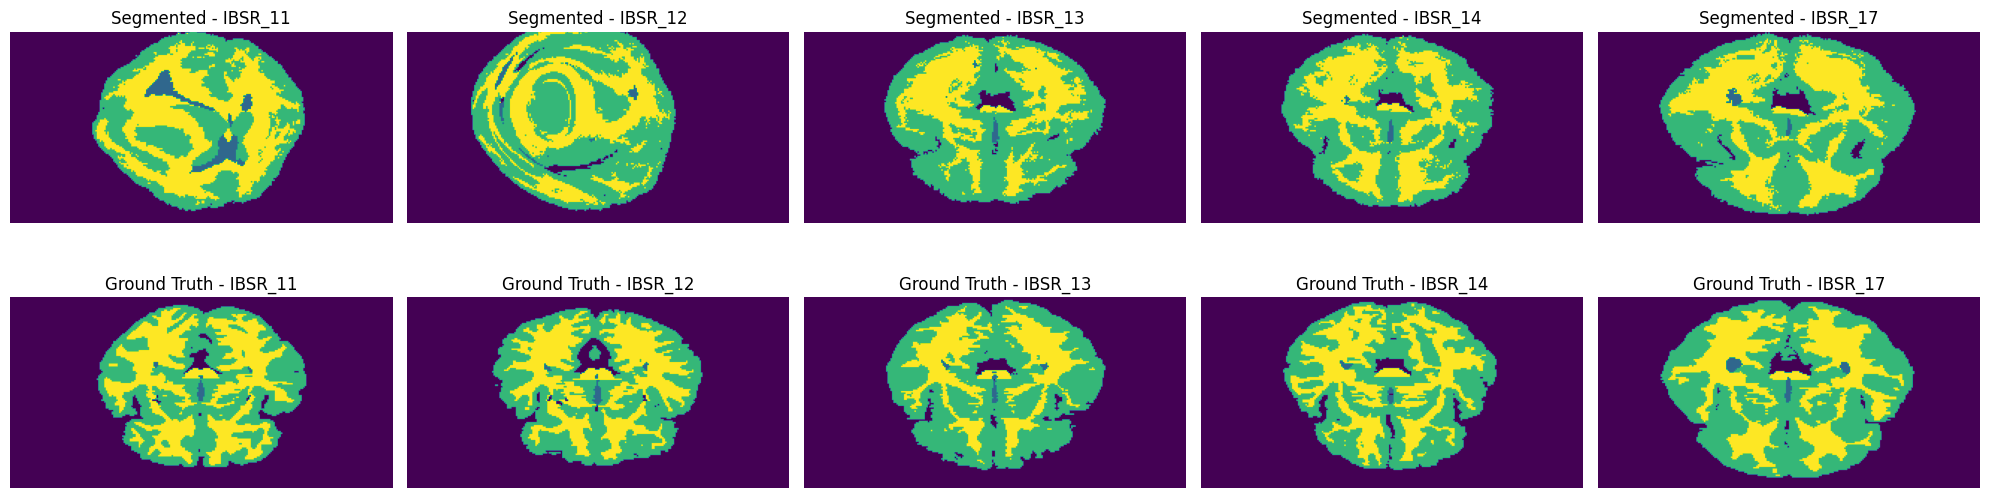

In [61]:
# Setup the plot 
fig, axs = plt.subplots(2, 5, figsize=(20, 6))

# Plot the segmented images 
for k, valid_dir in enumerate(VALID_DATASET_PATH.iterdir()):
    if k >= 5:
        break

    # Extract the image ID from the directory name
    image_id = valid_dir.stem

    # Define the slice number to be displayed
    slice_number = 125

    # Reading the ground truth label for the image
    valid_label_path = valid_dir / f'{image_id}_seg.nii.gz'
    valid_label = sitk.GetArrayFromImage(sitk.ReadImage(str(valid_label_path)))

    # Reading the segmented label for the image
    valid_seg_path = valid_dir / f'{image_id}_seg_reg_bspline.nii.gz'
    valid_seg = sitk.GetArrayFromImage(sitk.ReadImage(str(valid_seg_path)))

    # Plotting the specified slice of the segmented image
    axs[0, k].imshow(valid_seg[slice_number, :, :], cmap='viridis')
    axs[0, k].set_title(f'Segmented - {image_id}')
    axs[0, k].axis('off')  # Turn off axis labels and ticks

    # Plotting the same slice of the ground truth image
    axs[1, k].imshow(valid_label[slice_number, :, :], cmap='viridis')
    axs[1, k].set_title(f'Ground Truth - {image_id}')
    axs[1, k].axis('off')  # Turn off axis labels and ticks

# Adjust the layout of the plots to prevent overlap
plt.tight_layout()
# Display the plot
plt.show()


- **Compute dice scores**

In [62]:
# Initialize a list to store Dice scores for each image
dice_scores = []

# Iterate over each image in the validation dataset
for k, valid_dir in enumerate(VALID_DATASET_PATH.iterdir()):
    
    # Extract image ID from the directory name
    image_id = valid_dir.stem

    # Read the ground truth segmentation label
    valid_label_path = valid_dir / f'{image_id}_seg.nii.gz'
    valid_label = sitk.GetArrayFromImage(sitk.ReadImage(str(valid_label_path)))
    
    # Read the segmented image after rigid registration
    valid_seg_path = valid_dir / f'{image_id}_seg_reg_bspline.nii.gz'
    valid_seg = sitk.GetArrayFromImage(sitk.ReadImage(str(valid_seg_path)))

    # Calculate Dice scores comparing the segmented image to the ground truth
    scores = utils.dice_score(valid_label, valid_seg)

    # Append the image ID to the scores for identification
    scores['ImageID'] = image_id
    dice_scores.append(scores)

# Convert the list of Dice scores to a pandas DataFrame
df_dice_scores = pd.DataFrame(dice_scores)
df_dice_scores = df_dice_scores.set_index('ImageID')
df_dice_scores.columns = ['Background', 'CSF', 'GM', 'WM']

# Calculate mean and standard deviation for each class
mean_scores    = df_dice_scores.mean()
std_dev_scores = df_dice_scores.std()

# Calculate the average of the mean and standard deviation
avg_mean    = mean_scores.mean()
avg_std_dev = std_dev_scores.mean()

# Display the DataFrame with mean and standard deviation
print("Dice Scores:")
print(df_dice_scores)
print("\nMean (DSC):")
print(mean_scores)
print("\nStandard Deviation (DSC):")
print(std_dev_scores)

print(f"\nAverage of Mean (DSC)     : {avg_mean}")
print(f"Average of Std. Dev. (DSC): {avg_std_dev}")

Dice Scores:
         Background       CSF        GM        WM
ImageID                                          
IBSR_11    0.980640  0.168559  0.471792  0.523500
IBSR_12    0.960086  0.021008  0.386179  0.332504
IBSR_13    0.993416  0.643100  0.775439  0.677256
IBSR_14    0.993669  0.712266  0.781097  0.719550
IBSR_17    0.992244  0.730037  0.794121  0.685930

Mean (DSC):
Background    0.984011
CSF           0.454994
GM            0.641726
WM            0.587748
dtype: float64

Standard Deviation (DSC):
Background    0.014433
CSF           0.334519
GM            0.196666
WM            0.161478
dtype: float64

Average of Mean (DSC)     : 0.6671196514519713
Average of Std. Dev. (DSC): 0.17677393006365522


- **Compute Hausdorff Distance**

In [63]:
# Initialize a list to store Hausdorff distances for each image
hd_scores = []

# Iterate over each image in the validation dataset
for k, valid_dir in enumerate(VALID_DATASET_PATH.iterdir()):
    
    # Extract image ID from the directory name
    image_id = valid_dir.stem

    # Read the ground truth segmentation label and segmented image
    valid_label_path = valid_dir / f'{image_id}_seg.nii.gz'
    valid_label = sitk.GetArrayFromImage(sitk.ReadImage(str(valid_label_path)))
    valid_seg_path = valid_dir / f'{image_id}_seg_reg_bspline.nii.gz'
    valid_seg = sitk.GetArrayFromImage(sitk.ReadImage(str(valid_seg_path)))

    # Calculate Hausdorff distances
    hd = utils.hausdorff_distance(valid_label, valid_seg)
    hd['ImageID'] = image_id
    hd_scores.append(hd)

# Convert the list of Hausdorff distances to a pandas DataFrame
df_hd_scores = pd.DataFrame(hd_scores)
df_hd_scores = df_hd_scores.set_index('ImageID')
df_hd_scores.columns = ['Background', 'CSF', 'GM', 'WM']

# Display the DataFrame
print("Hausdorff Distances:")
print(df_hd_scores)

# Calculate mean and standard deviation for each class
mean_scores    = df_hd_scores.mean()
std_dev_scores = df_hd_scores.std()

# Calculate the average of the mean and standard deviation
avg_mean       = mean_scores.mean()
avg_std_dev    = std_dev_scores.mean()

# Display the DataFrame with mean and standard deviation
print("\nMean (HD):")
print(mean_scores)
print("\nStandard Deviation (HD):")
print(std_dev_scores)

print(f"\nAverage of Mean (HD)     : {avg_mean}")
print(f"Average of Std. Dev. (HD): {avg_std_dev}")

Hausdorff Distances:
         Background       CSF        GM        WM
ImageID                                          
IBSR_11    9.380832  5.477226  9.797959  7.937254
IBSR_12    9.643651  6.403124  8.602325  9.643651
IBSR_13    6.557439  4.000000  7.549834  7.071068
IBSR_14    6.403124  3.741657  7.483315  7.211103
IBSR_17    6.244998  4.123106  8.124038  7.874008

Mean (HD):
Background    7.646009
CSF           4.749023
GM            8.311494
WM            7.947417
dtype: float64

Standard Deviation (HD):
Background    1.709734
CSF           1.143888
GM            0.948065
WM            1.023822
dtype: float64

Average of Mean (HD)     : 7.163485532413555
Average of Std. Dev. (HD): 1.2063773637650208


- **Compute Average Volumetric Difference**

In [64]:
# Initialize a list to store AVD scores for each image
avd_scores = []

# Iterate over each image in the validation dataset
for k, valid_dir in enumerate(VALID_DATASET_PATH.iterdir()):
    # Extract image ID from the directory name
    image_id = valid_dir.stem

    # Read the ground truth segmentation label
    valid_label_path = valid_dir / f'{image_id}_seg.nii.gz'
    valid_label = sitk.GetArrayFromImage(sitk.ReadImage(str(valid_label_path)))

    # Read the segmented image after B-spline registration
    valid_seg_path = valid_dir / f'{image_id}_seg_reg_bspline.nii.gz'
    valid_seg = sitk.GetArrayFromImage(sitk.ReadImage(str(valid_seg_path)))

    # Calculate AVD for each label in the segmented image
    scores = utils.volumetric_difference(valid_label, valid_seg)

    # Append the image ID to the scores for identification
    scores['ImageID'] = image_id
    avd_scores.append(scores)

# Convert the list of AVD scores to a pandas DataFrame and set index to ImageID
df_avd_scores = pd.DataFrame(avd_scores)
df_avd_scores = df_avd_scores.set_index('ImageID')
df_avd_scores.columns = ['Background', 'CSF', 'GM', 'WM']

print("Average Volumetric Difference:")
print(df_avd_scores)

# Calculate mean and standard deviation for each label
mean_scores = df_avd_scores.mean()
std_dev_scores = df_avd_scores.std()

# Calculate the overall average of the mean and standard deviation
avg_mean = mean_scores.mean()
avg_std_dev = std_dev_scores.mean()

# Display the DataFrame with mean and standard deviation
print("\nMean (AVD) :")
print(mean_scores)
print("\nStandard Deviation (AVD):")
print(std_dev_scores)

print(f"\nAverage of Mean (AVD)     : {avg_mean}")
print(f"Average of Std. Dev. (AVD): {avg_std_dev}")

Average Volumetric Difference:
         Background        CSF         GM         WM
ImageID                                             
IBSR_11    3.137327  64.851531  16.096704  40.577436
IBSR_12    5.143619  68.135347  28.051922  76.767627
IBSR_13    0.447211  24.585860  10.554853  39.777947
IBSR_14    0.799288   4.552341   2.103383  11.999233
IBSR_17    0.602162  17.904862   2.647785  15.647631

Mean (AVD) :
Background     2.025922
CSF           36.005988
GM            11.890929
WM            36.953975
dtype: float64

Standard Deviation (AVD):
Background     2.060298
CSF           28.773960
GM            10.745733
WM            25.898507
dtype: float64

Average of Mean (AVD)     : 21.719203598181842
Average of Std. Dev. (AVD): 16.869624373239468


- **Display the statistical analysis**

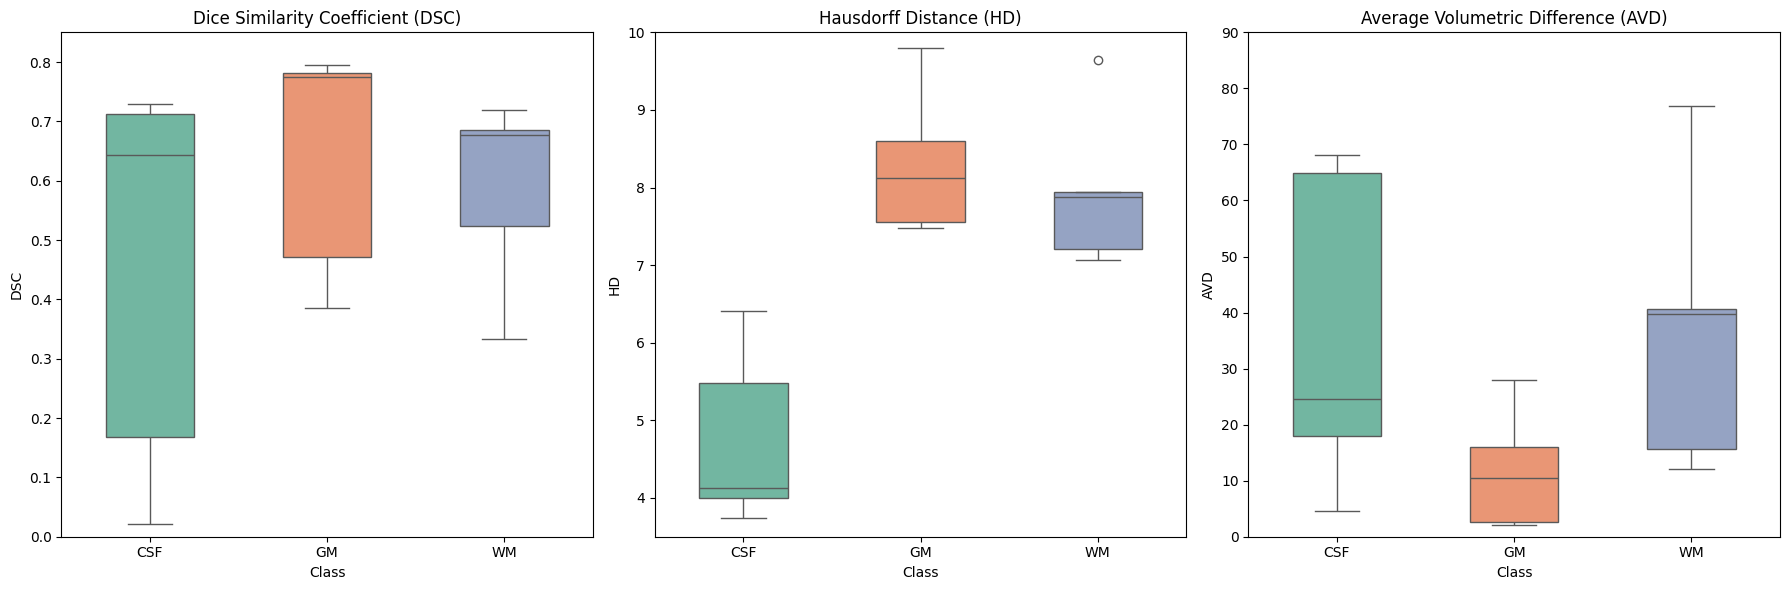

In [73]:
# Reshape the data into a long format
df_dice_long = df_dice_scores.melt(var_name='Class', value_name='DSC')
df_hd_long   = df_hd_scores.melt(var_name='Class', value_name='HD')
df_avd_long  = df_avd_scores.melt(var_name='Class', value_name='AVD')

# Combine the data into a single DataFrame
combined_data = pd.concat([df_dice_long, df_hd_long, df_avd_long], keys=['DSC', 'HD', 'AVD'])

# Correcting the DataFrame structure for combined data
combined_data = combined_data.reset_index(level=0).reset_index(drop=True)
combined_data.rename(columns={'level_0': 'Metric'}, inplace=True)

# Remove the 'Background' class from the DataFrame
combined_data = combined_data[combined_data['Class'] != 'Background']

# Number of unique classes
num_classes = combined_data['Class'].nunique()

# Define a color palette with the exact number of unique classes
palette = sns.color_palette("Set2", n_colors=num_classes)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

# DSC Plot
sns.boxplot(ax=axes[0], x='Class', y='DSC', hue='Class', data=combined_data[combined_data['Metric'] == 'DSC'], width=0.5, palette=palette)
axes[0].set_title('Dice Similarity Coefficient (DSC)')
axes[0].set_ylim([0.0, 0.85])  

# HD Plot
sns.boxplot(ax=axes[1], x='Class', y='HD', hue='Class', data=combined_data[combined_data['Metric'] == 'HD'], width=0.5, palette=palette)
axes[1].set_title('Hausdorff Distance (HD)')
axes[1].set_ylim([3.5, 10])  

# AVD Plot
sns.boxplot(ax=axes[2], x='Class', y='AVD', hue='Class', data=combined_data[combined_data['Metric'] == 'AVD'], width=0.5, palette=palette)
axes[2].set_title('Average Volumetric Difference (AVD)')
axes[2].set_ylim([0, 90])  

# Remove the legends
for ax in axes:
    ax.legend([],[], frameon=False)

plt.tight_layout()
plt.show()

# Result Summary

In [27]:
# Function to combine mean and standard deviation 
combine_mean_std = lambda mean, std: f"{mean:.3f} ± {std:.3f}"

# Function to calculate the average of the mean and std dev for each metric
average_of_means_stds = lambda df: combine_mean_std(df.mean().mean(), df.std().mean())

# Compute Mean and Standard Deviation for each metric, then combine them
combined_dice = [combine_mean_std(mean, std) for mean, std in zip(df_dice_scores.mean(), df_dice_scores.std())]
combined_hd   = [combine_mean_std(mean, std) for mean, std in zip(df_hd_scores.mean(), df_hd_scores.std())]
combined_avd  = [combine_mean_std(mean, std) for mean, std in zip(df_avd_scores.mean(), df_avd_scores.std())]

# Calculate averages of means and std devs for each metric
avg_dice = average_of_means_stds(df_dice_scores)
avg_hd   = average_of_means_stds(df_hd_scores)
avg_avd  = average_of_means_stds(df_avd_scores)

# Creating structured data for the table
summary_data = [
    ["DSC", *combined_dice, avg_dice],
    ["HD", *combined_hd, avg_hd],
    ["AVD", *combined_avd, avg_avd]
]

# Convert to DataFrame
summary_df = pd.DataFrame(summary_data, columns=["Metric", "Background", "CSF", "GM", "WM", "Avgerage"])

# Display the table using tabulate
print("\nSummary Table:")
print(tabulate(summary_df, headers='keys', tablefmt='pretty', showindex=False))


Summary Table:
+--------+---------------+-----------------+-----------------+----------------+----------------+
| Metric |  Background   |       CSF       |       GM        |       WM       |    Avgerage    |
+--------+---------------+-----------------+-----------------+----------------+----------------+
|  DSC   | 0.991 ± 0.002 |  0.671 ± 0.055  |  0.780 ± 0.037  | 0.702 ± 0.015  | 0.786 ± 0.027  |
|   HD   | 7.285 ± 0.407 |  4.245 ± 0.471  |  7.514 ± 0.419  | 7.166 ± 0.252  | 6.552 ± 0.387  |
|  AVD   | 1.032 ± 0.610 | 19.646 ± 11.766 | 16.031 ± 12.551 | 10.848 ± 7.465 | 11.889 ± 8.098 |
+--------+---------------+-----------------+-----------------+----------------+----------------+


### --------------------------------------------------->END OF CODE<-------------------------------------------------------------